# Trabajo Práctico 1
Alumno: Juan Antonio Zuloaga Mellino

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from pathlib import Path
from IPython.display import Markdown, display

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

## 1. Entrene una red de Hopfield ‘82 con un conjunto de imágenes binarias.

Se encuentran 2 tamaños distintos en las imágenes de prueba, por lo que se las subdivide en 2 grupos:

In [3]:
ImageNames45x60=[
  "images/paloma.bmp",
  "images/quijote.bmp",
  "images/torero.bmp",
];

ImageNames50x50=[  
  "images/panda.bmp",
  "images/perro.bmp", 
  "images/guyFawkes.bmp"
]

1) De tamaño 45x60

In [4]:
def nameFromPath(path):
    return Path(path).with_suffix("").name

In [5]:
def PlotFiles(fileNames):
    f, subplots = plt.subplots(1, 3)
    for path,splt in zip( fileNames, subplots):
        splt.imshow(plt.imread(path))
        splt.set_title(nameFromPath(path))
        splt.axis('off')

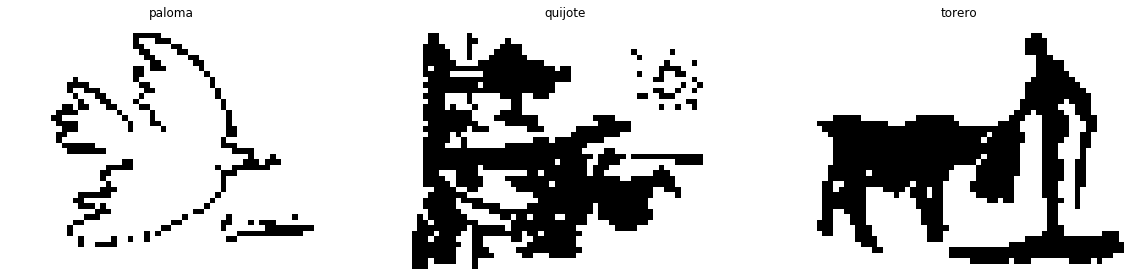

In [11]:
PlotFiles(ImageNames45x60)

2) De tamaño 50x50

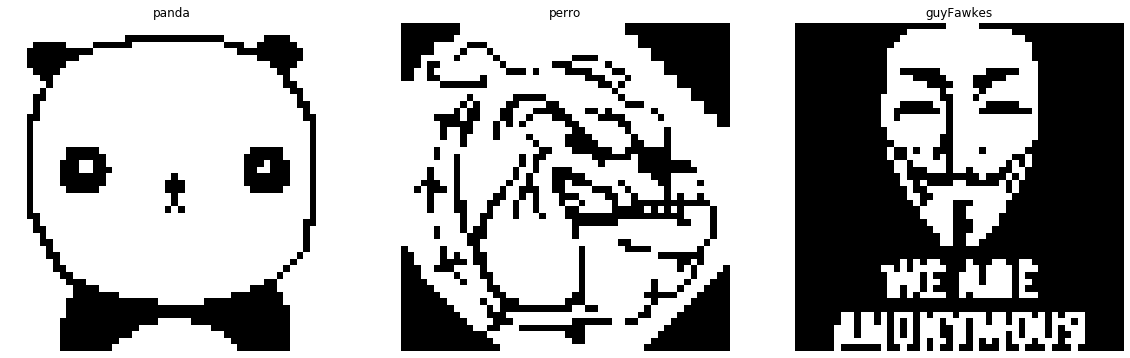

In [12]:
PlotFiles(ImageNames50x50)

In [13]:
# Definición de funciones auxiliares:

In [14]:
def signo(val):
  return (val >= 0)*2-1

In [15]:
def LoadImages(image_file_names):
    #Carga de las Imagenes  
    return [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names]
    #return np.squeeze( [ (plt.imread(file_name)[:,:,0] / 255 * 2 -1 ).reshape(-1,1) for file_name in image_file_names], axis=2 )

In [16]:
def PlotImage(pobj,imgArray):
    pobj.imshow(( imgArray >= 0 ).astype("double"),cmap='gray')
    #pobj.axis('off')
    pobj.xaxis.set_ticks([])
    pobj.yaxis.set_ticks([])
    pobj.spines['top'].set_visible(False)
    pobj.spines['right'].set_visible(False)
    pobj.spines['bottom'].set_visible(False)
    pobj.spines['left'].set_visible(False)

El entrenamiento de la red de Hopfield consiste en armar una matriz de pesos sinápticos.

Para un conjunto de imágenes se calcula la matriz de pesos como:

$\mathbf{W} = \sum_{i=1}^n \mathbf{z}_i \cdot \mathbf{z}_i^\mathbf{T} - p \cdot \mathbf{I}$

Donde $p$ es la cantidad de patrones, $\mathbf{z_{i}}$ es un vector columna de tamaño $n$ con el $i$-ésimo patrón a aprender y $\mathbf{I}$ es la matriz identidad tamaño $n \times n$

In [650]:
def CalculateWeights(Images):
    return np.sum( [ img.dot(img.transpose())-np.eye(len(img)) for img in Images ] , 0 )

In [651]:
def hopfield(seed,w,N,M):
    outVal = np.copy(seed);
    iteration = 1;
    changed = True;
    while(changed):
        changed = False;
        for i in np.random.permutation(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            outVal[i]=hi
    #PlotImage(plt.gca(),outVal.reshape(N,M))
    return outVal

In [652]:
def AutoTest(SourceImages, TargetImages, W,N,M):
    #chequeo si aprendio evaluando las mismas imagenes.
    return [ np.all(hopfield(src,W,N,M) == tgt) for src,tgt in zip(SourceImages, TargetImages)]

### a) Verifique si la red aprendió las imágenes enseñadas.

In [40]:
def DoesLearn(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip([nameFromPath(path) for path in ImageNames], Learned)],columns=["Image","Learned"]).set_index(["Image",])

Procesamiento de imágenes de 40x60:

In [41]:
DoesLearn(ImageNames45x60,45,60)

,Learned
Image,
paloma,True
quijote,True
torero,True


Procesamiento de imágenes de 50x50:

In [42]:
DoesLearn(ImageNames50x50,50,50)

,Learned
Image,
panda,True
perro,True
guyFawkes,True


Se verifica que se aprendieron ambos grupos de 3 imágenes.

### b) Evalúe la evolución de la red al presentarle versiones alteradas de las imágenes aprendidas: agregado de ruido, elementos borrados o agregados.

#### Ruido

Se le agrega ruido digital a las imágenes. Invirtiendo cada pixel de la imágen con una probabilidad *p*

In [43]:
def AddNoise(image,level):
    return image * (( np.random.rand(* image.shape) > level ).astype(np.int32) * 2 - 1);

In [85]:
def TestNoise(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
            
    levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]    
    #f, subplots = plt.subplots(len(levels), len(ImageNames))
    
    df = pd.DataFrame(columns=["Image"]+levels)
    df["Image"]=[nameFromPath(path) for path in ImageNames]
    
    #for lvl,pltRow in zip(levels,subplots):
    for lvl in levels:
        ImagesWithNoise = [ AddNoise(image,lvl) for image in Images ]
        f, pltRow = plt.subplots(1, len(ImageNames))
        
        for image,pltobj in zip(ImagesWithNoise,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("$p =%.2g$" % lvl)
        
        
        df[lvl] = AutoTest(ImagesWithNoise,Images,W,N,M)
        
    
    return df.set_index(["Image",]).rename_axis("p", axis="columns")

Procesamiento de imágenes de 40x60:

p,0.01,0.05,0.10,0.20,0.30,0.40,0.50
Image,,,,,,,
paloma,True,True,True,True,True,True,False
quijote,True,True,True,True,True,True,False
torero,True,True,True,True,True,True,False


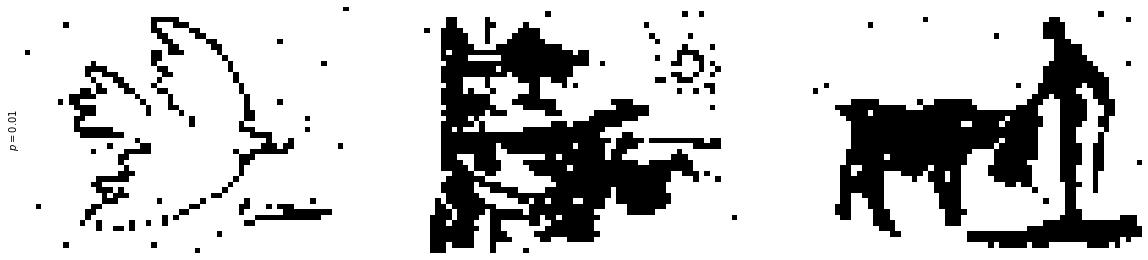

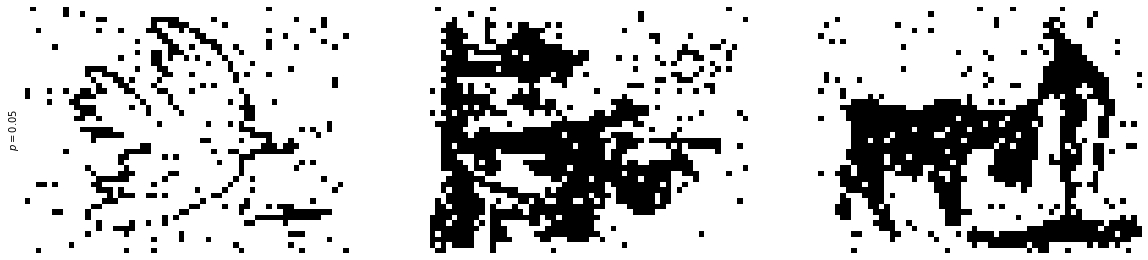

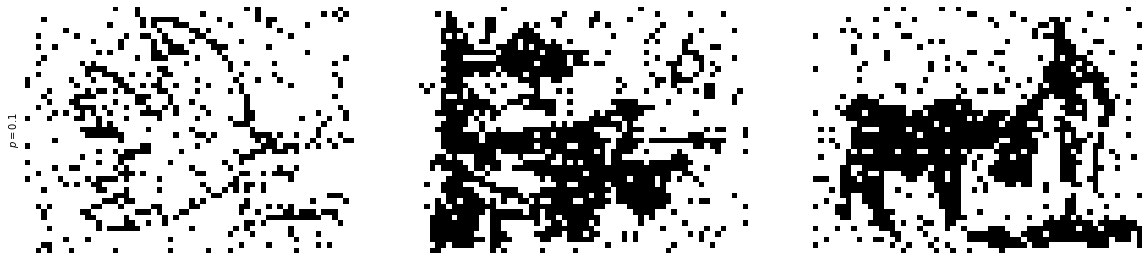

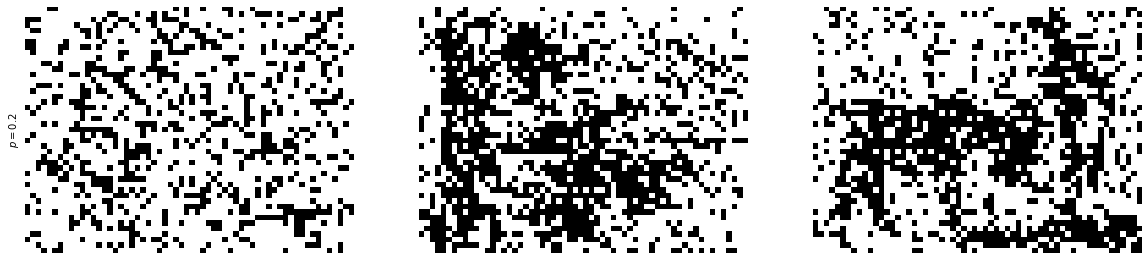

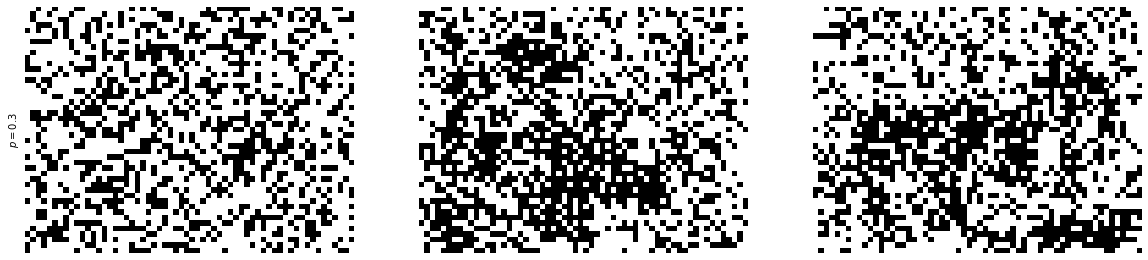

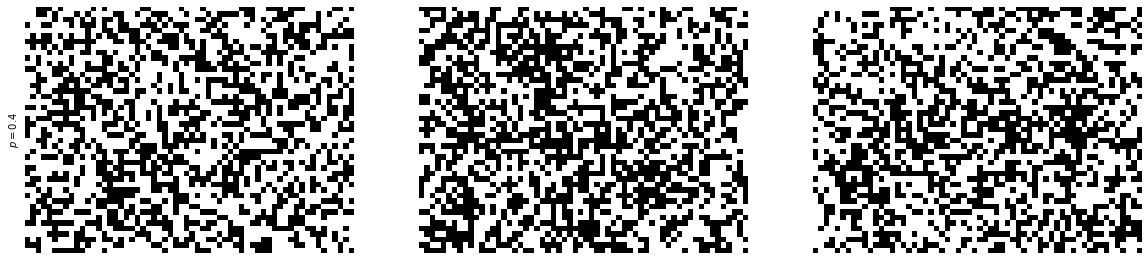

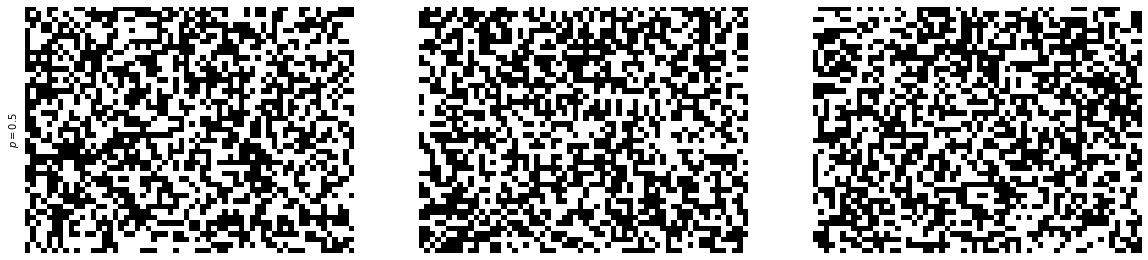

In [86]:
TestNoise(ImageNames45x60,45,60)

Procesamiento de imágenes de 50x50:

p,0.01,0.05,0.10,0.20,0.30,0.40,0.50
Image,,,,,,,
panda,True,True,True,True,True,True,False
perro,True,True,True,True,True,True,False
guyFawkes,True,True,True,True,True,True,False


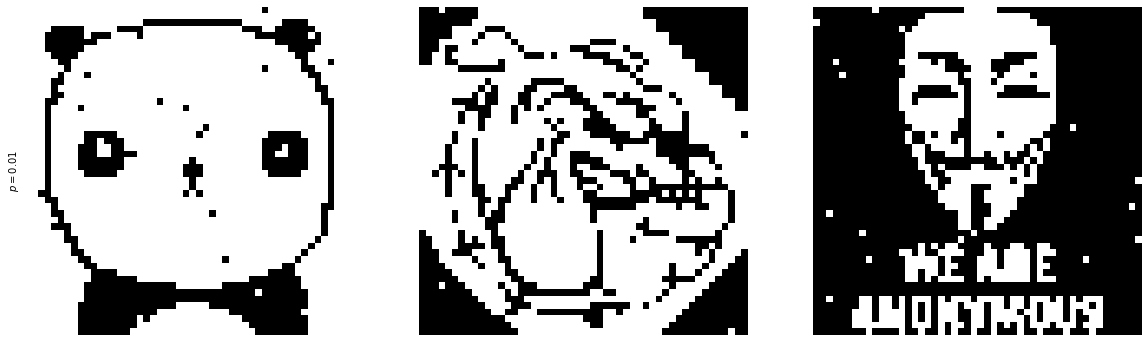

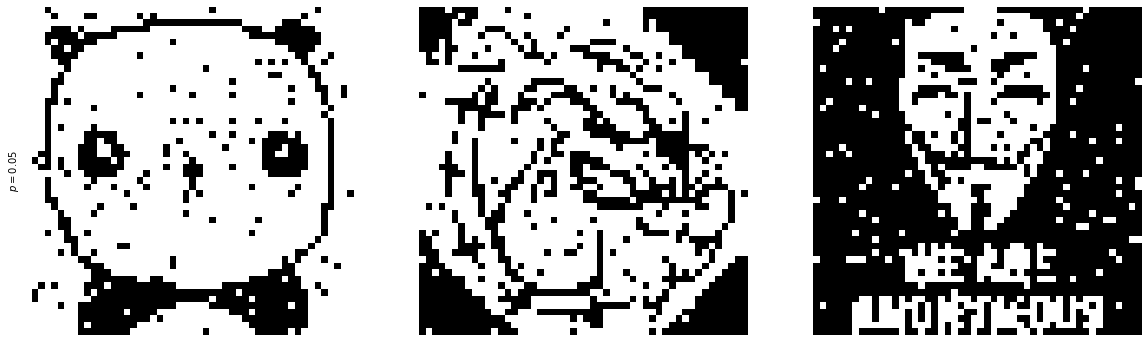

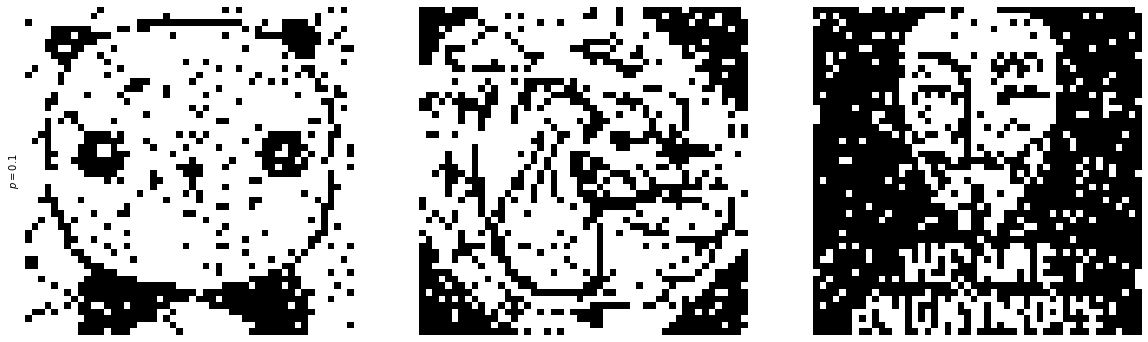

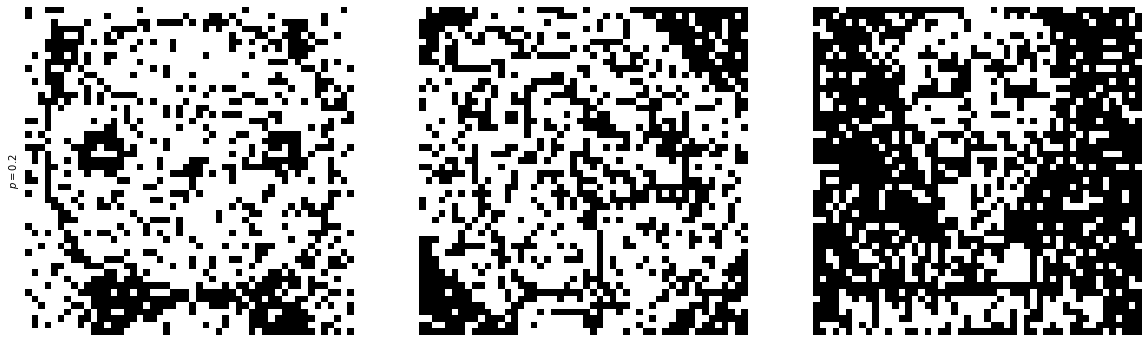

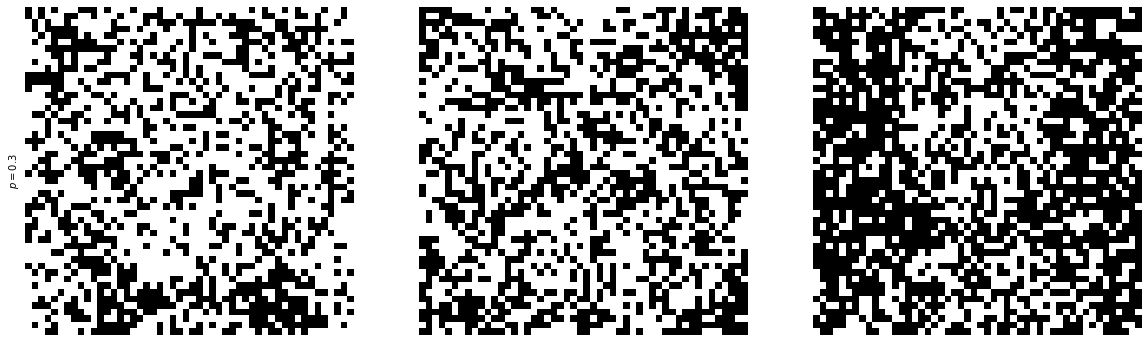

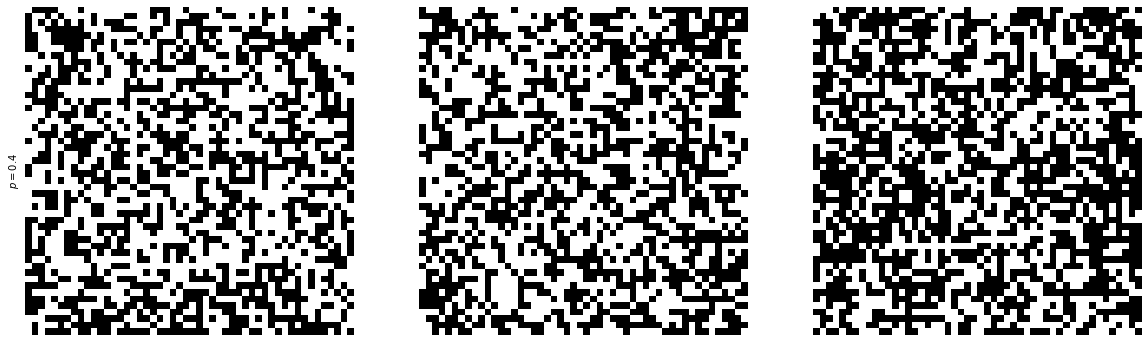

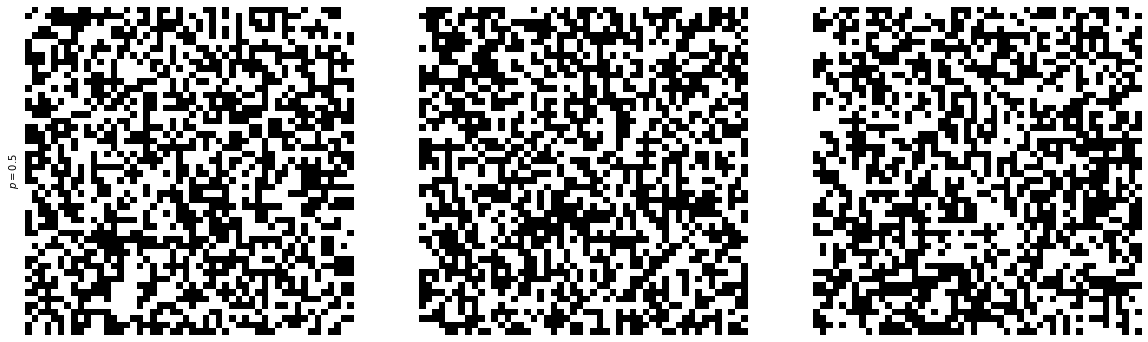

In [87]:
TestNoise(ImageNames50x50,50,50)

Repetidos ensayos mostraron que para 3 imágenes el algoritmo es robusto a ruido digital hasta $p=0.4$. Con $p=0.5$ el algoritmo converje a la imagen equivocada más frecuentemente de lo que acierta. Para $p \gt 0.5$ el atractor cambia a la imágen inversa.

#### Máscaras

Se ensayaron máscaras rectangulares que cubren distintos porcentajes de las imágenes de prueba, y se las usó como entrada en el algoritmpo de Hopfield.

In [88]:
def CreateMask(N,M,lvl):
    mask=np.zeros([N,M])
    mask[0:int(np.floor(N*lvl)),0:int(np.floor(M*lvl))]=1
    return mask

In [89]:
def MaskImages(Images,N,M,lvl):
    mask=CreateMask(N,M,lvl).reshape(-1,1)
    return [ ((image + mask) >= 0 ).astype(np.int32) * 2 - 1 for image in Images  ]

In [90]:
def TestMasked(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    levels = np.arange(0.2,0.8,0.2)
    
    df = pd.DataFrame(columns=["Image"]+list(levels))
    df["Image"]=[nameFromPath(path) for path in ImageNames]
    
    for lvl in levels:
        MaskedImages = MaskImages(Images,N,M,lvl)
        
        f, pltRow = plt.subplots(1, len(ImageNames))
        for image,pltobj in zip(MaskedImages,pltRow):
            PlotImage(pltobj,image.reshape(N,M))
        pltRow[0].set_ylabel("mask=%.2g" % lvl)
        
        df[lvl] = AutoTest(MaskedImages,Images,W,N,M)
        
    return df.set_index(["Image",]).rename_axis("mask %", axis="columns")

Procesamiento de imágenes de 40x60:

mask %,0.2,0.4,0.6,0.8
Image,,,,
paloma,True,True,True,True
quijote,True,True,False,False
torero,True,True,True,False


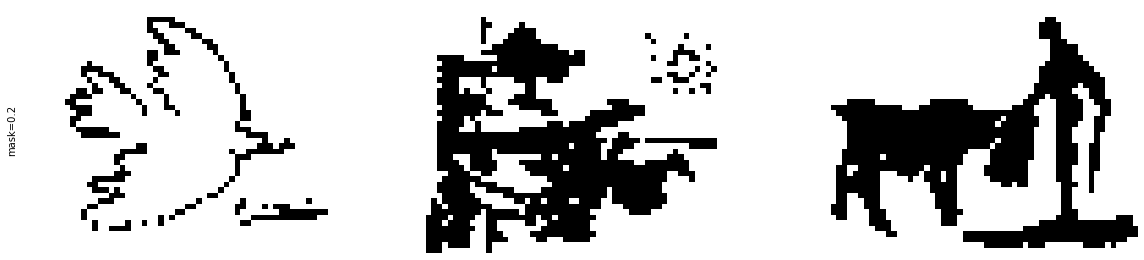

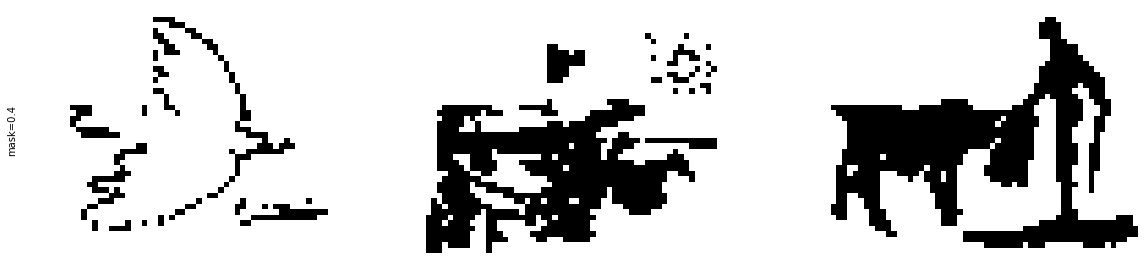

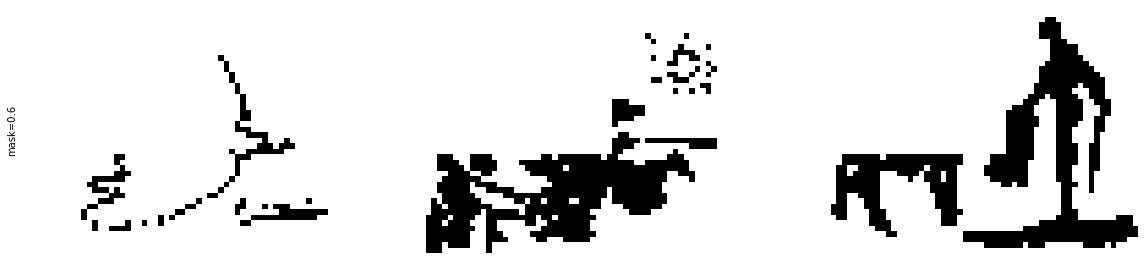

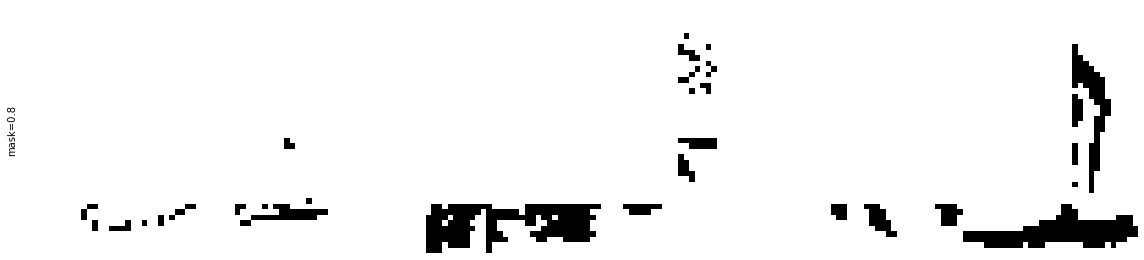

In [91]:
TestMasked(ImageNames45x60,45,60)

Procesamiento de imágenes de 50x50:

mask %,0.2,0.4,0.6,0.8
Image,,,,
panda,True,True,True,True
perro,True,True,True,True
guyFawkes,True,True,True,False


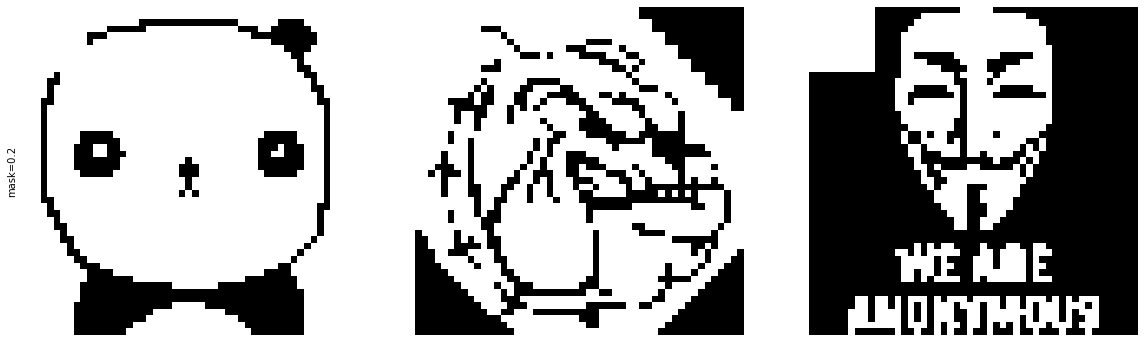

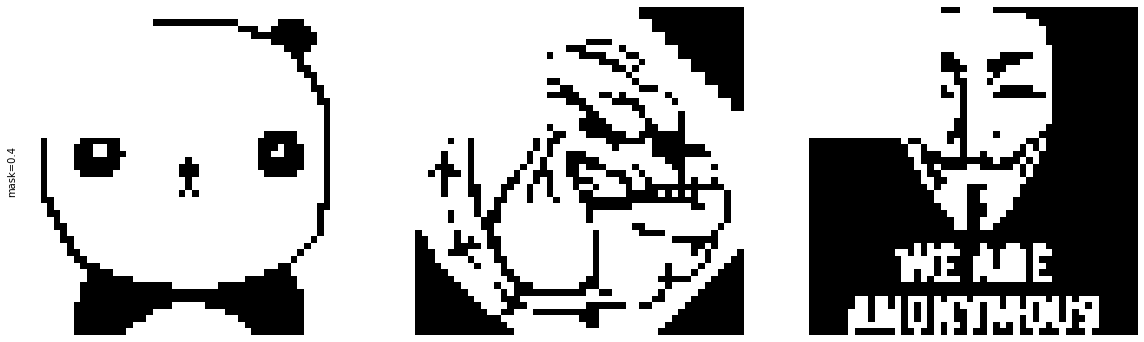

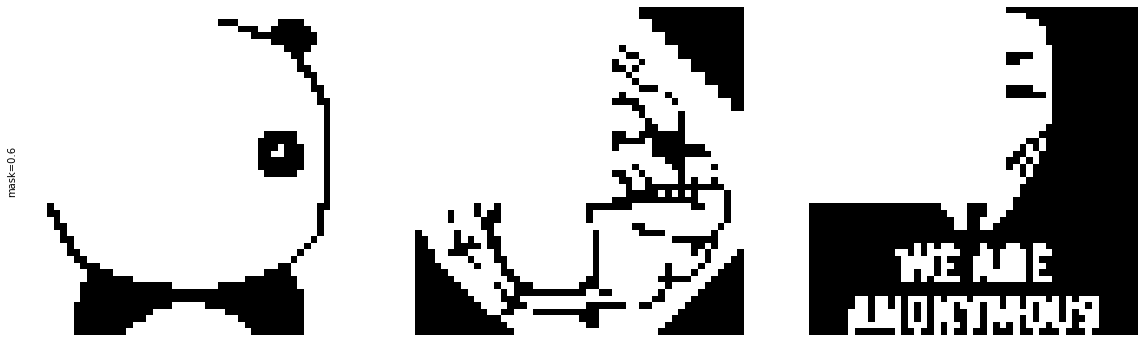

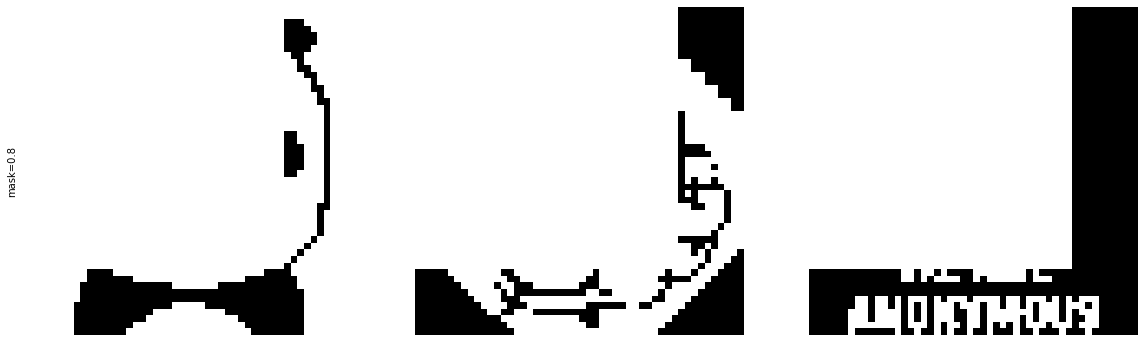

In [92]:
TestMasked(ImageNames50x50,50,50)

Se observa que el algoritmo tolera máscaras que cubren hasta el 60% de la imágen, pero cuando cubre el 80% algunas imágenes comienzan a fallar.

### c) Evalúe la existencia de estados espurios en la red: patrones inversos y combinaciones de un número impar de patrones. *(Ver Spurious States, en la sección 2.2, Hertz, Krogh & Palmer, pág. 24)*.

Validación de los patrones negativos:

In [262]:
def DoesLearnNegative(ImageNames,h,w):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    negatives=[ -1*image for image in Images]
    
    f, pltRow = plt.subplots(1, len(ImageNames))
    for image,pltobj in zip(negatives,pltRow):
        PlotImage(pltobj,image.reshape(h,w))
        
    Learned=AutoTest(negatives ,negatives,W,h,w)
    #Pandas dataframe for table display
    return pd.DataFrame([x for x in zip([nameFromPath(path) for path in ImageNames], Learned)],columns=["Image","Learned"]).set_index(["Image",])

Procesamiento de imágenes de 45x60:

,Learned
Image,
paloma,True
quijote,True
torero,True


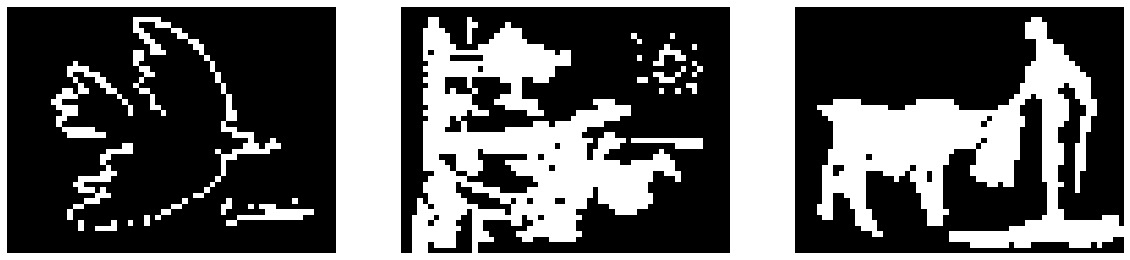

In [263]:
DoesLearnNegative(ImageNames45x60,45,60)

Procesamiento de imágenes de 50x50

,Learned
Image,
panda,True
perro,True
guyFawkes,True


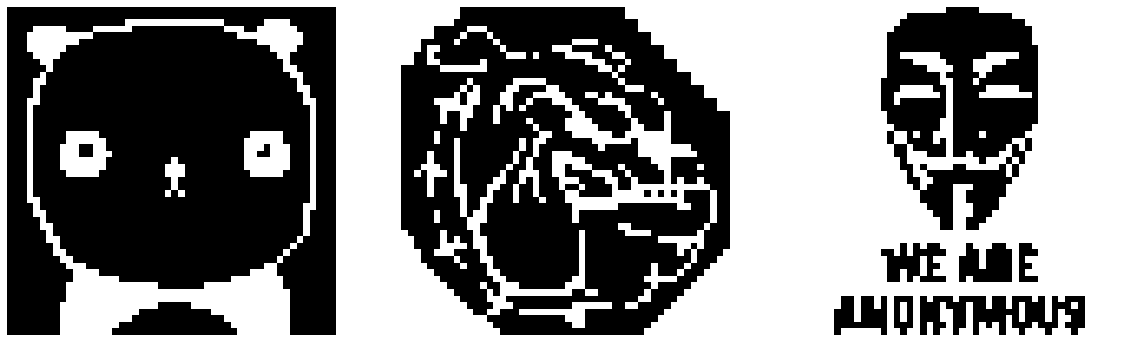

In [264]:
DoesLearnNegative(ImageNames50x50,50,50)

Los patrones negativos fueron aprendidios correctamente. Validado esto, se arma un conjunto de patrones expandido con los patrones positivos y negativos y se evaluan todas las combianaciones suma de 3 elementos de este conjunto.

Esto volverá a evaluar los patrones positivos y negativos, ya que si se suman 3 patrones A + B + C, donde A = -B, A y B se cancelan y queda el patrón C.

In [441]:
def PlotImages(Images,N,M, columns):
    i = 0
    for index,image in Images.items():
        if i == 0:
            f, pltRow = plt.subplots(1, columns)
        PlotImage(pltRow[i],image.reshape(N,M))
        pltRow[i].set_title(index)
        i+=1
        if i == columns:
            i=0
    
    while ( i > 0 and columns > i ):
        PlotImage(pltRow[i],np.ones((N,M)).astype(np.int32))
        i+=1

In [442]:
def GenerateOddSpurious(Images):
    ExtendedImages = np.squeeze( Images + [-1 * image for image in Images], axis=2)
    combs = list(itertools.combinations(range(len(ExtendedImages)),3))
    return [ (ExtendedImages[list(comb)].sum(axis=0) >= 0).astype(np.int32) * 2 - 1 for comb in combs ]
    

In [443]:
def formatCombs():
    
    k=list(itertools.combinations(["A","E","I","-A","-E","-I"],3))
    kf=["".join(
        [macrons[b] for b in a if [b[-1] for b in a].count(b[-1]) == 1 ] #remove sums
    ) for a in k]
    return kf

In [444]:
def GenerateOddSpuriousLabels(Labels):
    macrons={"A":"A","E":"E","I":"I","-A": u"\u0100", "-E": u"\u0112", "-I": u"\u012A"}
    ExtendedLabels = Labels + ["-"+l for l in Labels]    
    combs = list(itertools.combinations(range(len(ExtendedLabels)),3))
    CombLabels=[ [ExtendedLabels[coord] for coord in comb] for comb in combs ]
    SimplifyLabels= ["".join([macrons[l] for l in label if [l[-1] for l in label].count(l[-1]) == 1 ]) for label in CombLabels]
    return SimplifyLabels

In [445]:
def TestSpurious(ImageNames,N,M):
    Images=LoadImages(ImageNames)
    W=CalculateWeights(Images)
    
    Labels=["A","E","I"]
    
    SpuriousImages=GenerateOddSpurious(Images)
    SpuriousLabels=GenerateOddSpuriousLabels(Labels)    
    Learned=AutoTest(SpuriousImages ,SpuriousImages,W,N,M)
    
    #[ for i,l,r in zip(SpuriousImages,SpuriousLabels,Learned)]
    df=pd.DataFrame(zip(SpuriousLabels,SpuriousImages,Learned),columns=["Comb","Image","Learned"]).groupby("Comb").first()    
    #PlotImages( np.unique(SpuriousImages,axis=0), N,M, 4 )
    
    PlotImages( df["Image"], N,M, 4 )
    
            #Pandas dataframe for table display
    return df["Learned"].to_frame().transpose()    

Procesamiento de imágenes de 45x60:

Comb,A,AEI,AEĪ,AIĒ,AĒĪ,E,EIĀ,EĀĪ,I,IĀĒ,Ā,ĀĒĪ,Ē,Ī
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True


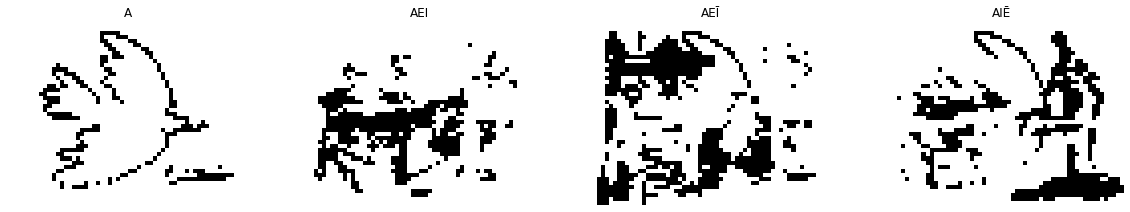

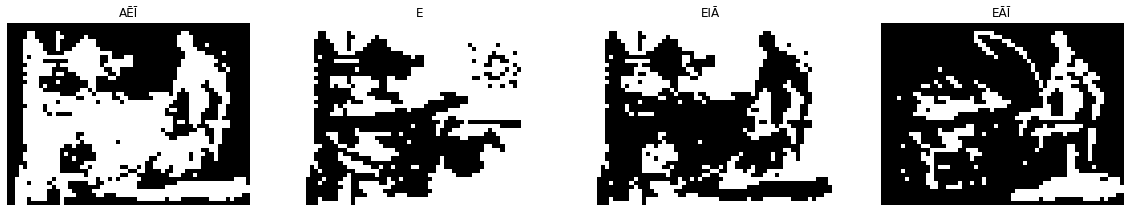

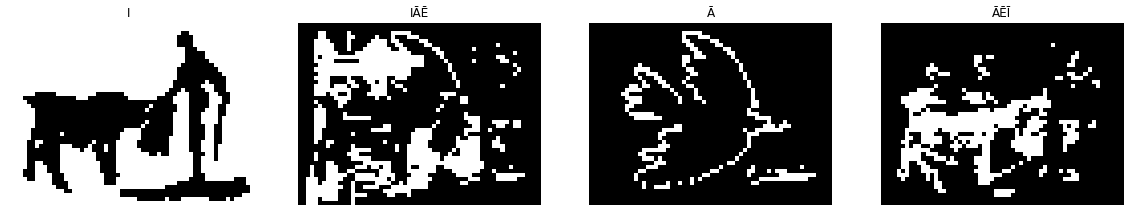

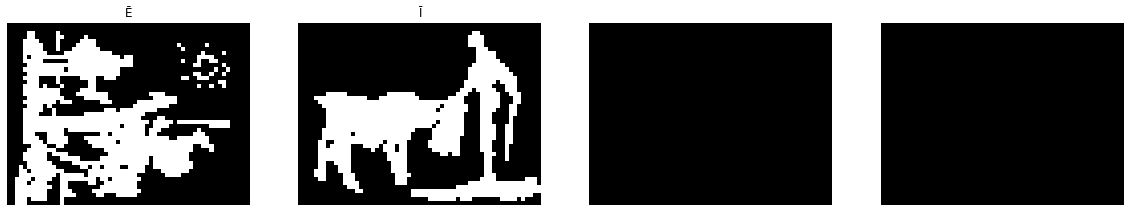

In [446]:
TestSpurious(ImageNames45x60,45,60)

Procesamiento de imágenes de 50x50

Comb,A,AEI,AEĪ,AIĒ,AĒĪ,E,EIĀ,EĀĪ,I,IĀĒ,Ā,ĀĒĪ,Ē,Ī
Learned,True,True,True,True,True,True,True,True,True,True,True,True,True,True


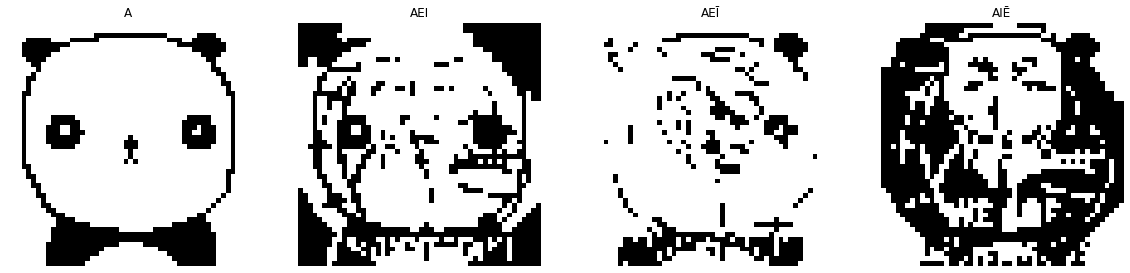

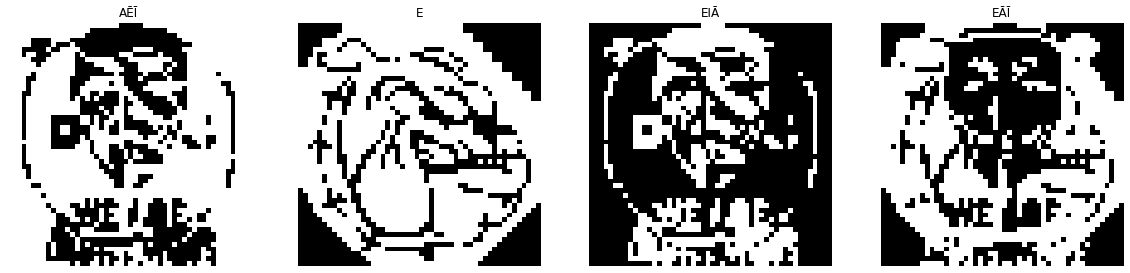

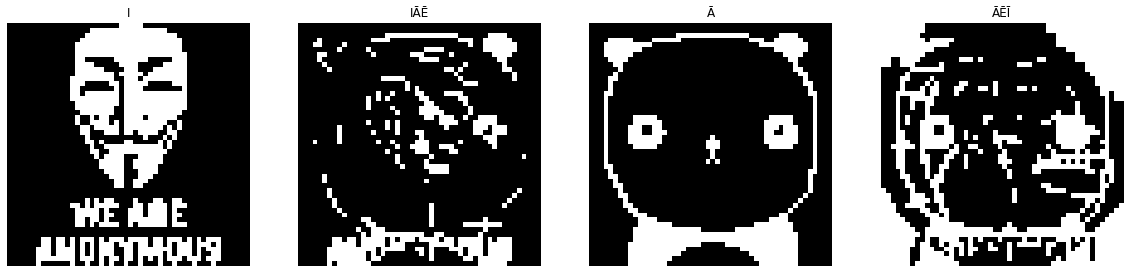

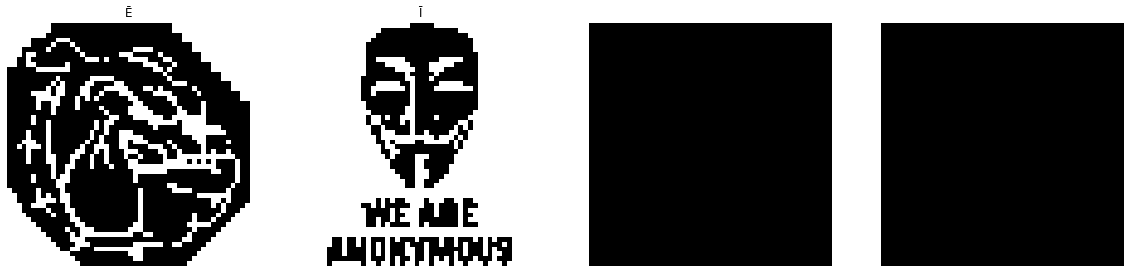

In [447]:
TestSpurious(ImageNames50x50,50,50)

Todos los patrones generados como suma de 3 patrones resultan en un patrón aprendido por la red para ambos conjuntos de imágenes.

### d) Realice un entrenamiento con todas las imágenes disponibles. ¿Es capaz la red de aprender todas las imágenes? Explique.

Para poder cargar todas las imágenes juntas es necesario primero homogeneizar el tamaño.

La homogeneización de tamaño se realizo con un padding al tamaño mínimo capaz de contener todas las imágenes.

El padding se realizó con 3 tipos de patrones distintos.

In [490]:
def LoadImagesWithPadding(ImageFileNames,N,M,paddingFunction):
    for image_name in ImageFileNames:
        base_image=(plt.imread(image_name)[:,:,0] / 255 ).astype(np.double) * 2 - 1
        padded_image=(paddingFunction(N,M) > 0.5).astype(np.int32).astype(np.double) * 2 - 1
        padded_image[:base_image.shape[0],:base_image.shape[1]] = base_image
        yield padded_image.reshape(-1,1)

In [491]:
def DoesLearnWithPadding(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    
    W=CalculateWeights(Images)
    Learned=AutoTest(Images,Images,W,h,w)
    
    df = pd.DataFrame([x for x in zip([nameFromPath(path) for path in ImageNames], Images, Learned)],columns=["Image","Pattern","Learned"]).set_index(["Image",])
    PlotImages(df["Pattern"],h,w,3)
    
    #Pandas dataframe for table display
    return df["Learned"].to_frame().transpose()



Padding con Zeros:

Image,paloma,quijote,torero,panda,perro,guyFawkes
Learned,False,True,False,True,True,True


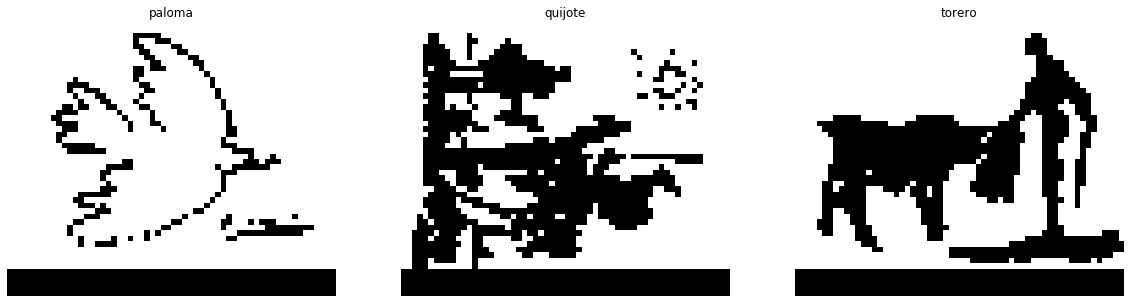

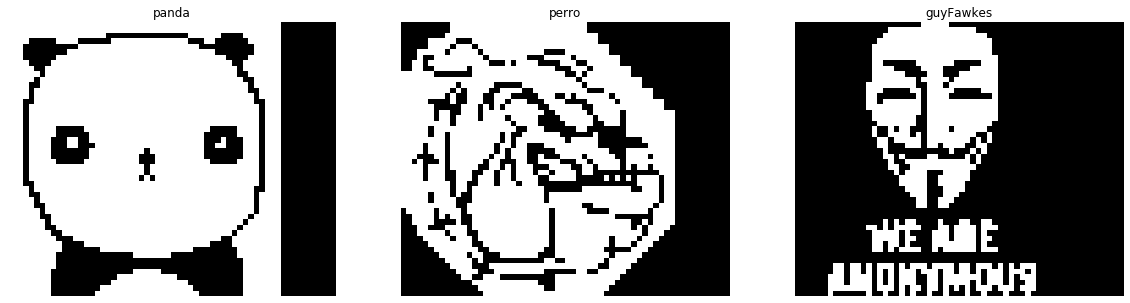

In [492]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

Padding con Unos:

Image,paloma,quijote,torero,panda,perro,guyFawkes
Learned,False,False,False,False,False,True


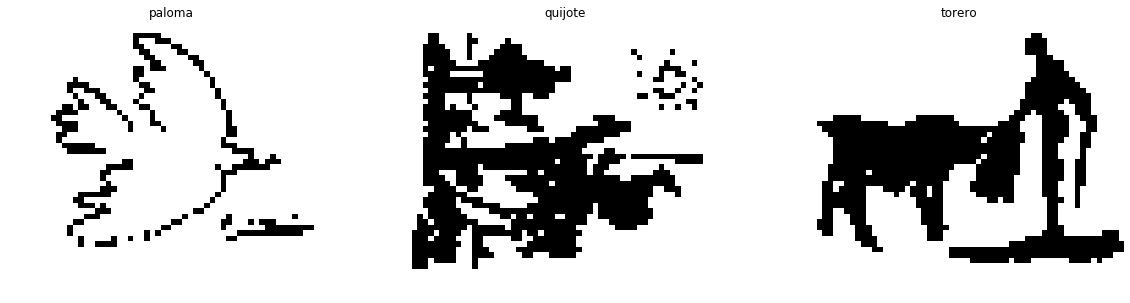

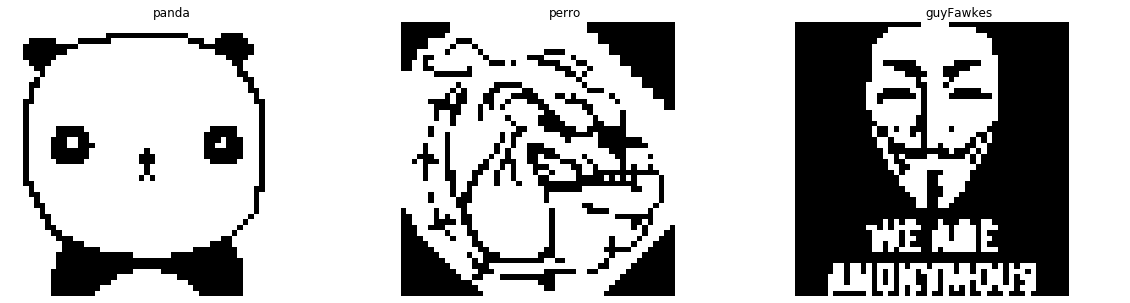

In [493]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

Padding con patrón pseudoaleatorio:

Image,paloma,quijote,torero,panda,perro,guyFawkes
Learned,False,True,True,True,True,True


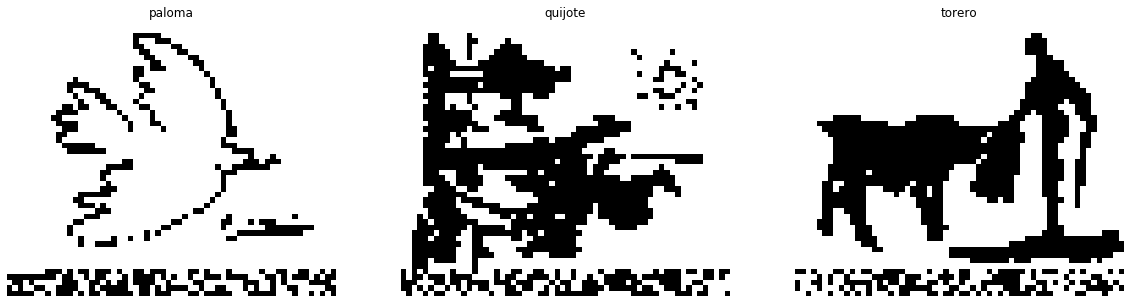

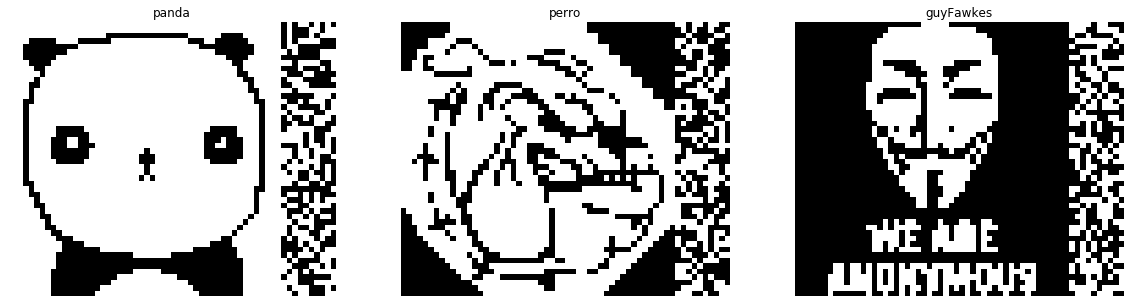

In [494]:
DoesLearnWithPadding(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

En ninguno de los casos la red pudo aprender todos los patrones, pero los resultados variaron con el tipo de padding utilizado.

El padding el blanco fue el que produjo mayores solapamientos y solo aprendió un patrón.

El padding en negro produjo que 2 patrones no pudieran ser aprendidos.

El padding con patrones pseudoaleatorios produjo que 1 o 2 patrones nos se pudieran aprender dependiendo de la corrida.

Patrones a los que converje el algoritmo:

In [495]:
def ConvergingPatterns(ImageNames,h,w,paddingFunction):
    Images=list(LoadImagesWithPadding(ImageNames,h,w,paddingFunction))
    W=CalculateWeights(Images)
    df=pd.DataFrame([[nameFromPath(path),hopfield(image,W,h,w)] for path,image in zip(ImageNames,Images)],columns=["Image","Pattern"]).set_index("Image")
    PlotImages(df["Pattern"],h,w,3)

Padding con Zeros:

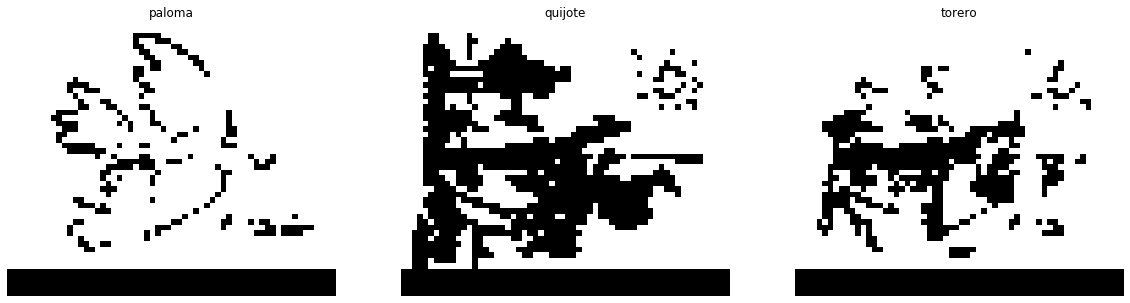

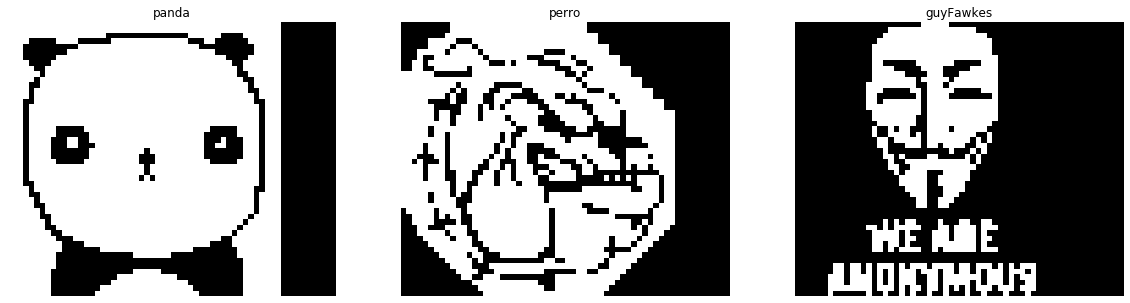

In [496]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.zeros([h,w]))

Padding con Unos:

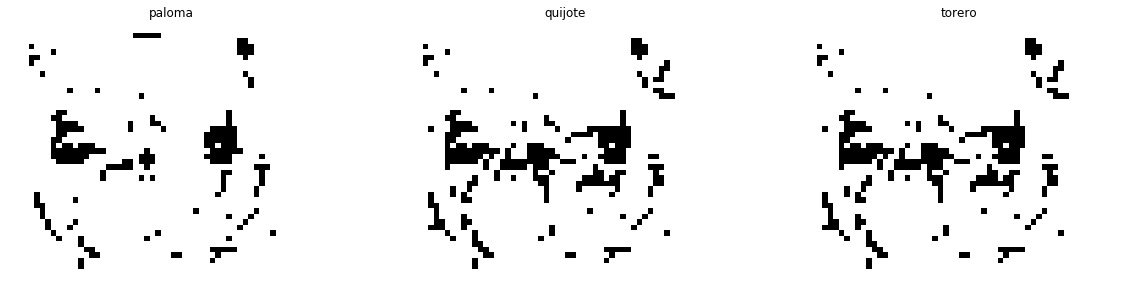

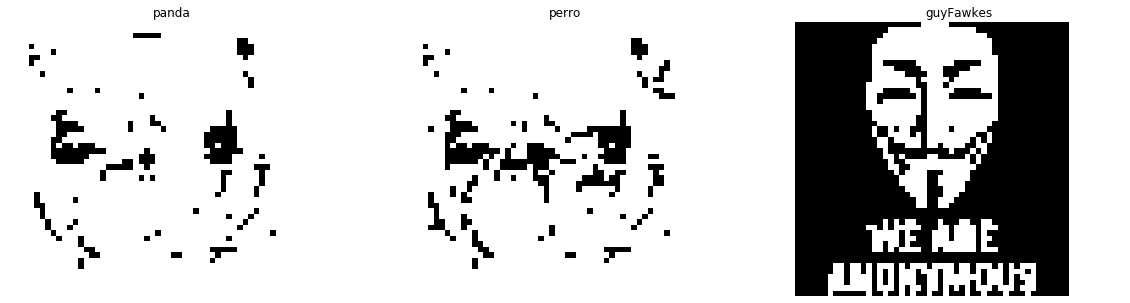

In [497]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,lambda h,w: np.ones([h,w]))

Padding pseudo aleatorio:

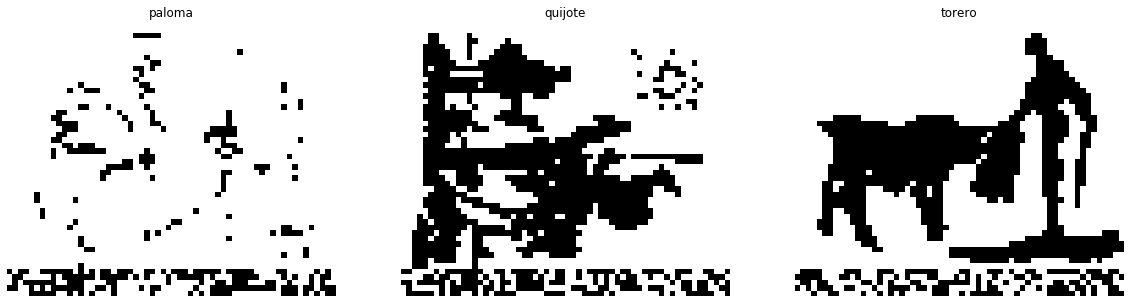

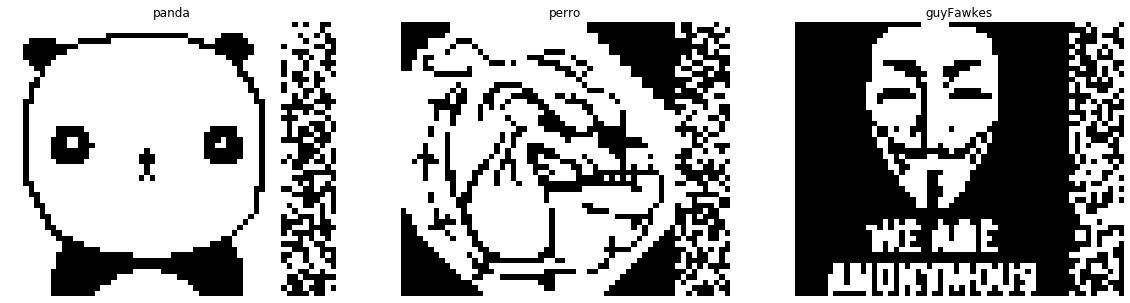

In [498]:
ConvergingPatterns(ImageNames45x60 + ImageNames50x50, 50,60,np.random.rand)

Al analizar dónde convergen los patrones que fallaron se observa que los patrones de salida contienen parte de la información del patrón de entrada. Por ejemplo las alas de la paloma y las patas del toro todavía pueden apreciarse para el caso del padding negro.

Se concluye que los patrones no son lo suficientemente ortogonales entre sí para ser aprendidos todos, o que la red es muy chica para ese fin.

## 2. Comprobar estadísticamente la capacidad de la red de Hopfield ‘82 calculando la cantidad máxima de patrones pseudo-aleatorios aprendidos en función del tamaño de la red.

###  a) Obtener experimentalmente los resultados de la siguiente tabla (los valores de la tabla corresponden a una iteración con actualización sincrónica).

In [502]:
tableHertzEtAl=pd.DataFrame([
    [0.001, 0.105],
    [0.0035, 0.138],
    [0.01,0.185],
    [0.05,0.37],
    [0.1,0.61]],columns=["Perror","pmax/N"]).set_index("Perror")
tableHertzEtAl

,pmax/N
Perror,
0.0010,0.105
0.0035,0.138
0.0100,0.185
0.0500,0.370
0.1000,0.610


In [503]:
def randImageGen(N,P):
    return [ (np.random.rand(N,1) > 0.5).astype(np.int32).astype(np.double) * 2 - 1  for _ in range(P)]

In [504]:
def calcPError(algo,imageGen,N,P):
    Images=imageGen(N,P)
    W=CalculateWeights(Images)
    return np.sum([(algo(image,W,N,1) != image ).astype(np.int32).sum()/N for image in Images ])/P

In [505]:
class ExceededMaxIterations(Exception):
    pass

In [506]:
def repeatPError(algo,imageGen,N,P):
    step=10
    acc=[]
    while(True):
        try:
            #Exception Shuld 
            acc+=[ calcPError(algo,imageGen,N,P) for _ in range(10) ]
        except ExceededMaxIterations as e:
            print(str(e))
            continue
         
        std = np.std(acc,ddof=1)
        if 1.96*std/np.sqrt(len(acc)) < 0.001: #2.32
            print(N,P,N/P,end='\r')
            break            
    return np.mean(acc)

In [507]:
def FillTable(algo, span ):
    df=pd.DataFrame(columns=["N","P","PError"]).set_index(["N","P"])

    for N in span:
        pError=0
        P=0
        while pError < 0.1:
            P+=1
            pError = repeatPError(algo,randImageGen,N,P)
            df.loc[(N,P),"PError"]=pError
            #print(N,P,pError),
    return df
    

In [539]:
def PlotCapacity(df, tableHertzEtAl):
    for N, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/ndf["N"],ndf["PError"],label="N= %i" % N)


    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)
    plt.legend(title="")
    plt.xlabel("pmax/N")
    plt.ylabel("Perror")

Capacidad de la red para Hopfield Síncrono:

In [533]:
def syncHopfield(seed,w,N,M,steps):
    outVal = np.copy(seed);
    #iteration = 1;
    changed = True;
    guard=steps
    newVal = np.zeros(outVal.shape);
    while(changed):
        guard-=1
        changed = False;
        for i in range(len(outVal)):
            hi=signo(w[i,:].reshape(1,-1).dot(outVal))
            changed |= (hi != outVal[i])
            newVal[i]=hi
        outVal=newVal
        
        if guard == 0:
            break
            #raise ExceededMaxIterations("Exceeded iterations range: N=%i, M=%i" % [M ,N])
            
    return outVal

In [20]:
def cleanLastPrintedLine():
    print(" " * 80, end='\r')

Se estimó mediante método de Montecarlo para distintos tamañaos de red ($N$) y distinta candidad de patrones a aprender ($Pmax$), el error esperado después de 1 paso del algoritmo de hopfield, con 3 decimales para un intervalo de confianza del 95%

Para detalles sobre la aplicacion de intervalos de confianza a estimadores calculados por método Montecarlo, ver <a hrf="https://www.valuationresearch.com/wp-content/uploads/kb/SpecialReport_MonteCarloSimulationTrials.pdf">OPTIMAL NUMBER OF TRIALS FOR MONTE CARLO SIMULATION</a>

In [ ]:
syncCapacity=FillTable(lambda a,b,c,d: syncHopfield(a,b,c,d,1), np.arange(10,70,10))
cleanLastPrintedLine()

In [ ]:
#syncCapacity.transpose()

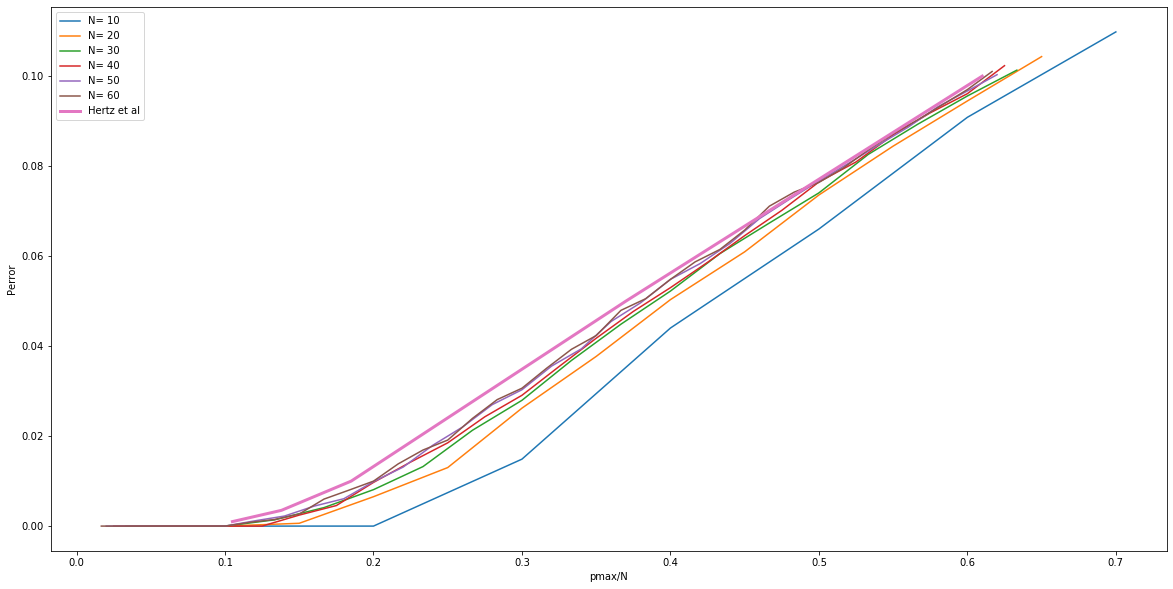

In [540]:
PlotCapacity(syncCapacity,tableHertzEtAl)

Si bien no se pudo reproducirla exactamente, se observa que las curvas se acercan a los valores de la tabla de Hertz conforme se incrementa la cantidad de neuronas N.

### b) Analice cómo cambia la capacidad de una red en función de la correlación entre patrones

Si definimos nuestra correlación como:

$\rho = \mathbb{E} \frac{\sum_{j} \xi_{j}^{\mu}\xi_{j}^{\nu}}{N}$

Si N es la cantidad de neuronas, las imágenes se correlacionaron de la siguiente manera:

- La primer imágen ($\nu = 1$)  es pseudo aleatoria
- La $\nu$-ésima imágen con $\nu > 1$ se compone de los valores de $(\nu-1)$ para algún $K < N$ posiciones elegidas al azar. El resto de los posiciónes toma valores aleatorios.


Esto producirá que para 2 patrones consecutivos

$\rho = \mathbb{E} \frac{\sum_{j=1}^{N} \xi_{j}^{\nu}\xi_{j}^{\nu-1}}{N}=\frac{\mathbb{E} \sum_{j=1}^{K} \xi_{j}^{\nu}\xi_{j}^{\nu-1} + \mathbb{E}\sum_{j=K+1}^{N} \xi_{j}^{\nu}\xi_{j}^{\nu-1}}{N} = \frac{K}{N}$

La sumatoria de la derecha corresponde a patrones pseudo-ortogonales por lo que su media es nula.

La sumatoria de la izquierda corresponed a patrones idénticos, por lo que el producto es siempre 1 y la sumatoria vale K

Con éste metodo podemos generar patrones con la correlación deseada.


In [542]:
def genCorrelatedImages(N,P,ro):
    Images=randImageGen(N,P)
    for n in range(1,P):
        rndIdx=np.random.choice(np.arange(N),int(np.floor(N*ro)),replace=False)
        Images[n][rndIdx]=Images[n-1][rndIdx]
    return Images

Se valida que las correlaciones den el resultado correcto, para pares de patrones con N = 10000

In [543]:
def correlationCalculator(ro,N):
    acc=[]
    while(True):   
        acc+=[ (imgs[0]*imgs[1]).sum() for imgs in [ genCorrelatedImages(N,2, ro) for _ in range(1000) ]]

        coor_est = np.mean(acc)/N
        cut_factor = 1.96 * np.std(acc,ddof=1)/np.sqrt(len(acc))
        print(ro,coor_est,cut_factor,end='\r')
        if cut_factor < 0.5:
            cleanLastPrintedLine()
            break
    return coor_est

In [ ]:
def evalCorr(N):
    df = pd.DataFrame(columns=["Corr deseada","Corr generada"]).set_index("ro")
    for ro in np.arange(0,1,0.1):
        df.loc[ro,"Corr"]=correlationCalculator(ro,N)    
    return df

In [545]:
expCorr=evalCorr(10000)

In [546]:
expCorr

,Corr
ro,
0.0,-6.04753e-05
0.1,0.0999917
0.2,0.200026
0.3,0.300002
0.4,0.399995
0.5,0.499973
0.6,0.60002
0.7,0.699965
0.8,0.799989


Se pude observar que los patrones se generan con la correlación deseada.

Se realiza el cálculo de capacidad para N=30

In [571]:
def corrFillTable(algo, N, span ):
    df=pd.DataFrame(columns=["ro","P","PError"]).set_index(["ro","P"])

    for ro in span:
        pError=0
        P=0
        while pError < 0.1:
            P+=1
            roundRo = np.floor(N*ro)/N
            pError = repeatPError(algo,lambda n,p:genCorrelatedImages(n,p,roundRo),N,P)
            df.loc[(roundRo,P),"PError"]=pError
            #print(N,P,pError),
    return df

In [595]:
def corrPlotCapacity(df,tableHertzEtAl,N):
    for ro, new_df in df.groupby(level=0):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/N,ndf["PError"],label="$ro = %0.1f$" % ro)
        
    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)        
    plt.xlabel("pmax/N")
    plt.ylabel("Perror")
    plt.legend()

In [ ]:
corrCapacity=corrFillTable(lambda a,b,c,d: syncHopfield(a,b,c,d,1), 30, np.arange(0,1,0.1))
cleanLastPrintedLine()

In [ ]:
corrCapacity

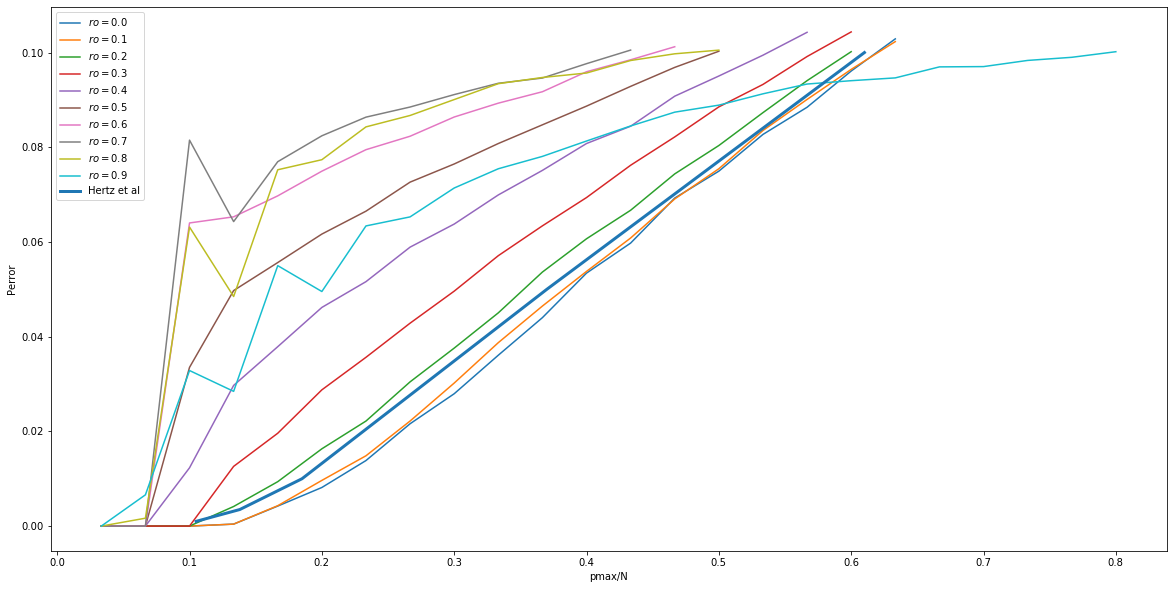

In [596]:
corrPlotCapacity(corrCapacity,tableHertzEtAl,30)

Se puede observar que para $\rho$ chicos la capacidad se ubica cerca de la teórica calculada por Herz. Pero conforme incrementa la correlación entre patrones, la capacidad cae hasta colapsar.

Es de notar que el método de generación de patrones correlacionados secuencialmente que se utilizó, donde se parte de una imagen A y se genra una imagen B con correlación $\rho$ con de A, y luego una imágen C con correlación $\rho$ con B implica que existe una correlación $\rho'< \rho$ entre A y C. Esa correlación no fue analizada en este trabajo.

## 3. Implemente una red de Hopfield ‘82 que aprenda patrones pseudo-aleatorios y estudie qué sucede con los patrones aprendidos cuando algunas interconexiones son eliminadas al azar.

Para un conjunto de patrones pesudoaleatorios se arma una red de Hopfield y se elimina cierto porcentaje de los pesos sinápticos progresiva y aletoriamente.

Repitiendo el experimento, mediante método de Montecarlo se estima el error medio después de un paso de Hopfield para distintos niveles de degradación de la matríz de pesos sinápticos.

In [655]:
def HoleFiller(W,proportional_step):
    holedW=np.copy(W)
    yield ( np.copy(holedW), 1 )
    
    shuffled_synapsis=np.random.permutation([ x for x in np.ndindex(* W.shape) if x[0]!=x[1] ])
    NCoord=len(shuffled_synapsis)
    step=np.floor(proportional_step * NCoord )
    i=1
    for coord in shuffled_synapsis:
        holedW[coord[0],coord[1]]=0
        if i%step == 0:
            yield ( np.copy(holedW), 1 - i/NCoord )
        i+=1
    
    if i%step!=1:
        yield ( np.copy(holedW), 1 - i/NCoord )
        

In [656]:
#testHoles
#list(HoleFiller(np.ones((10,10)),0.2))

In [657]:
def calcPWError(algo,imageGen,N,P,step):
    Images=imageGen(N,P)
    return [ (s, np.sum([(algo(image,W,N,1) != image ).astype(np.int32).sum()/N for image in Images ])/P )
                for W,s in HoleFiller(CalculateWeights(Images),step) ]

In [658]:
def repeatPErrorWithHoles(algo,imageGen,N,P,step):
    Error=calcPWError(algo,imageGen,N,P,step)
    s=[s for s,e in Error]
    acc=[ [e for s,e in Error], ]
    while(True):  
        acc+=[ [e for s,e in error] for error in [ calcPWError(algo,imageGen,N,P,step) for _ in range(10) ]]         
        std = np.std(acc,ddof=1,axis=0)
        if np.all(1.96*std/np.sqrt(len(acc)) < 0.01):
            break    
    return list(zip(itertools.repeat(P),s,np.mean(acc,axis=0)))

In [659]:
def holeCapacity(N):    
    P=1
    acc=[]
    PError = 0
    while PError < 0.1:
        print(N,P,PError,end='\r')
        result = repeatPErrorWithHoles(lambda a,b,c,d: syncHopfield(a,b,c,d,1),randImageGen, N, P,0.025)
        PError = np.min([x[-1] for x in result])
        acc+=result
        P+=1
    cleanLastPrintedLine()
    return pd.DataFrame(acc,columns=["P","Integrity","PError"]).set_index(["P","Integrity"])

### a) ¿Cómo cambia el error en función del porcentaje de sinapsis eliminadas?

In [ ]:
integrityDf=holeCapacity(30)

In [564]:
def holePlot(df):
    for P, new_df in df.groupby("P"):
        ndf=new_df.reset_index()
        plt.plot(1-ndf["Integrity"],ndf["PError"],label=P)
        
    #ndf=tableHertzEtAl.reset_index()
    #plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)    
    plt.legend(title="pmax")
    plt.ylim([0,0.1])
    plt.xlabel("Nivel de Degradación")
    plt.ylabel("Perror")
    plt.title("Degradación de una red de hopfield (N = 30)")

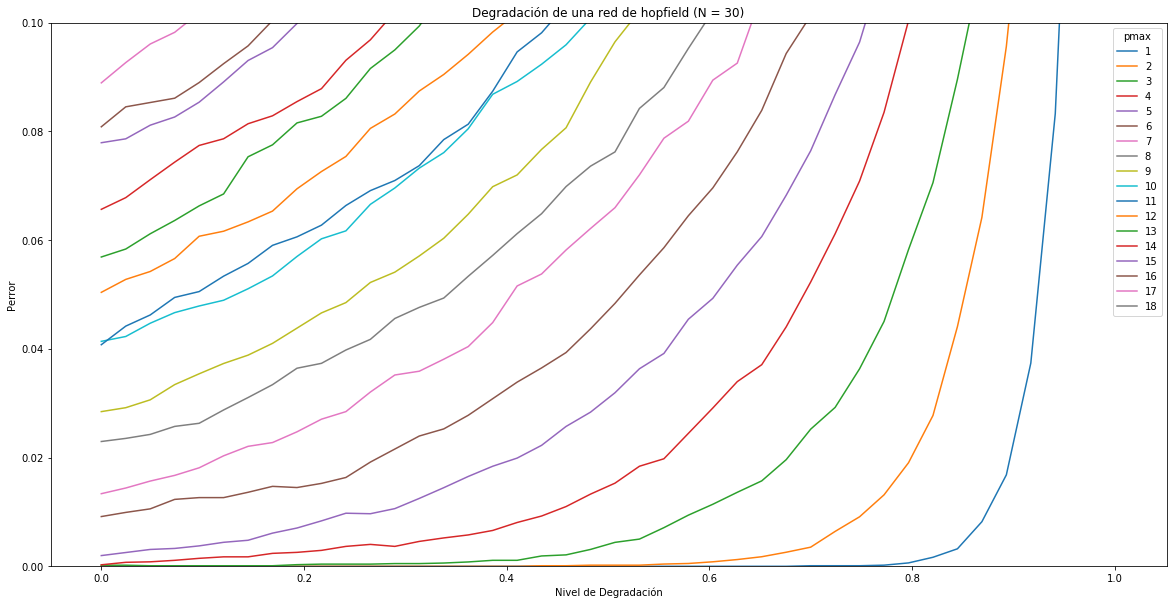

In [565]:
holePlot(integrityDf)
#ax.set_ylim([0, 0.1])

Se observa que al incrementar el porcetaje de sinapsis eliminadas respecto al total de sinapsis, al principio la red es robusta frente a estas degrdaciones,  pero llega un punto en que el error se dispara.

También, como era de esperarse, la tolerancia a la degradación es mayor, conforme menor es la cantidad de patrones aprendidos. Para el caso de pmax = 1 y pmax = 2, la tolerancia a la degradación es de 80% y 60% respectivamente, manteniendo errores bajos.

### b) ¿Cómo cambia la capacidad en función del porcentaje de sinapsis eliminadas?

In [599]:
def stepIterator(lst,step):
    i=0
    for x in lst:
        if i%step == 0:
            yield x
        i+=1
            

In [600]:
def holeCapacityPlot(df,tableHertzEtAl,N,skip):    
    for tg, new_df in stepIterator(reversed(tuple(df.groupby("Integrity"))),skip):
        ndf=new_df.reset_index()
        plt.plot(ndf["P"]/N,ndf["PError"],label="%.02f" % (1-tg))
        
    ndf=tableHertzEtAl.reset_index()
    plt.plot(ndf["pmax/N"],ndf["Perror"],label="Hertz et al", linewidth=3)        
    plt.ylim([0,0.1])
    plt.legend(title="Degradacion")
    plt.xlabel("pmax/N")
    plt.ylabel("Perror")
    plt.title("Cpacidad de la red de Hopfield para distintos niveles de degradación")

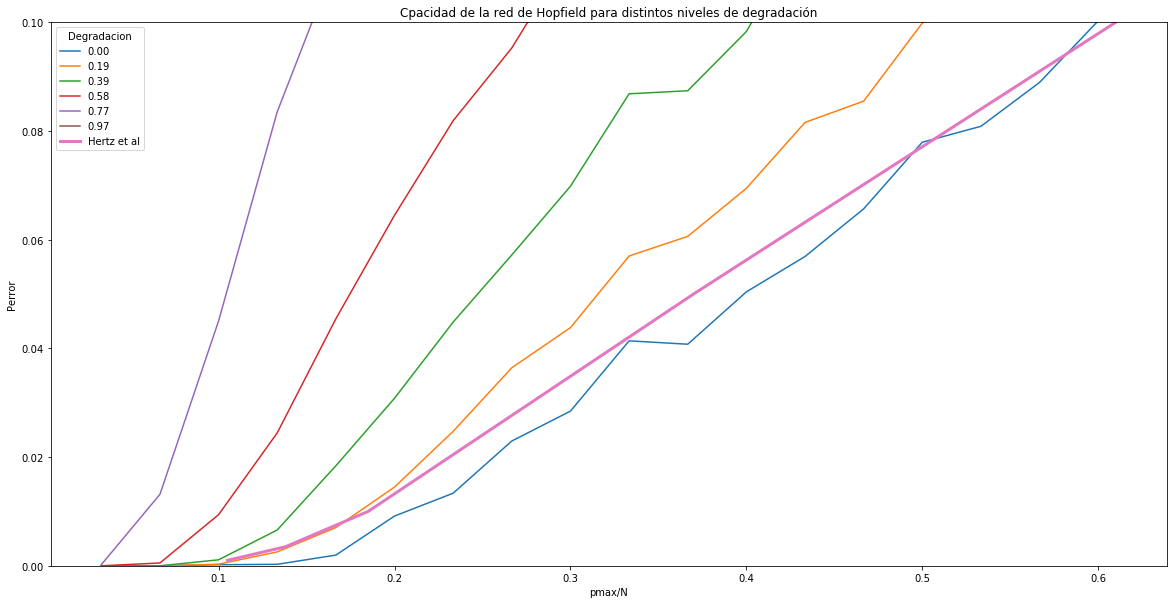

In [598]:
holeCapacityPlot(integrityDf,tableHertzEtAl,30,8)

En el gráfico de capacidad se puede observar como la probabilidad de error incrementa al aumentar el nivel de degradación de la red.

## 4. Simular un modelo de Ising en una y dos dimensiones. Encontrar la temperatura crítica para ambos casos

Se utiliza el algoritmo de metrópolis para simular un modelo de Ising.
Se toma como simplificación que la interacción de intercambio magnético vale 1 para los dipolos que están en contacto en la red, y 0 para el resto.

In [6]:
def isValidCoord(coord, shape):
    return np.all(coord >= 0) & np.all(coord < shape)

In [7]:
#def squareKernel(N):
#    if N % 2 == 0:
#        raise Exception("Only Odd Sizes Allowed")
#    center=int(np.floor(N/2))
#    base=np.zeros((N,N))
#    base[center,center]=1
#    return [ tuple(x - np.array((center,center))) for x,y in np.ndenumerate(base) if y == 0]

In [8]:
def neighbours(coord, shape):
    kernel = [(0,1),(0,-1),(1,0),(-1,0)] # squareKernel(5)
    for mask in kernel:    
        neighbour_coord = np.add(coord,mask)
        if isValidCoord(neighbour_coord,shape):
            yield tuple(neighbour_coord)

In [9]:
def isingWeights(lattice):
    flat_indices=np.arange(lattice.size).reshape(lattice.shape)
    W=np.zeros((lattice.size,lattice.size))

    for coord,row in np.ndenumerate(flat_indices):
        for neighbour in neighbours(coord,flat_indices.shape):        
            W[row,flat_indices[neighbour]]=1
    return W

In [10]:
def rand2dImageGen(dim):
    return (np.random.rand(*dim) > 0.5).astype(np.int32).astype(np.double) * 2 - 1

In [11]:
def hasCurieTemp(lattice):
    #Todos los elementos son 1 o -1  
    #print( "Corto", np.abs(lattice.sum()), lattice.size)
    return np.abs(lattice.sum()) == lattice.size
    

Calculamos la energía de ising como: 

$H= -\frac{1}{2}\sum_{ij} w_{ij} \sigma_j \sigma_i + \frac{1}{2} \sum_{ij} w_{ij}$

El segundo término corresponde al mínimo de energía, cuando todos los spin están alineados y es una corrección para que la energía sea positiva.

In [12]:
def Energy(lattice,w):    
    lattice=lattice.reshape(-1,1)
    energy_offset=0.5 * np.sum(w) # Sumo la cantidad de aristas
    return -0.5*lattice.transpose().dot(w).dot(lattice).item() + energy_offset

Se utilizó como constante de Boltzmann, $k' = 8.3E-3$ que es un valor ad-hoc para que la temperatura de curie de los experimentos de aproximadamente 1000

In [13]:
def isChangeAccepted(delta_E,T):        
    k=0.0008240694685686903
    if delta_E <= 0:
        return True    
    isAccepted = np.random.rand() < np.exp(-delta_E/k/T)   
    return isAccepted
    

Consideramos que se estabiliza la energía en un nivel de temperatura, cuando podemos determinar la media de energía con 1% de error y un 95% de confianza.

In [14]:
def energyIsStable(old_Energies):
        break_condition = 1.96 * np.std(old_Energies,ddof=1)/np.sqrt(len(old_Energies))
        target = np.mean(old_Energies)*.01
        print("Will Stop if: %1.03f < %1.03f" % (break_condition,target),end="\r")
        if np.isnan(break_condition):
            print(old_Energies)
            print("Desvio", np.std(old_Energies,ddof=1))
            raise Exception("nan")
        return break_condition < target
    

In [15]:
def formatSpins(lattice):        
    return "\n".join( [ "".join(["\u2B06" if x > 0 else "\u2B07" for x in row ]) for row in lattice])

In [16]:
def plotSpins(lattice):
        plt.imshow(lattice)
        plt.axis('off')
        plt.show()

Esta implementación de algoritmo de metrópolis decrementa la temperatura en pasos $T_{k+1} = 0.9 T_k$

El paso de temperatura se da cuando mediante Montecarlo, se obtiene una estimación de la energia media que se considera esable.

Se trabaja con la hipótesis que si converje el estimador de la energía media, también el sistema se estabiliza en ese nivel de temperatura.

In [18]:
def metropolis(seed,w,T):
    original_shape=seed.shape
    outVal = np.copy(seed).reshape(-1,1)    
    iteration = 1;
    results = []
    old_Energies = [ Energy(outVal,W), ]
    
    print("Estado inicial, T = {:.2e}".format(T))
    plotSpins(outVal.reshape(original_shape))
    
    while not hasCurieTemp(outVal):
        while True:
            prev_E=old_Energies[-1]            
            for _ in range(30):
                for i in np.random.permutation(len(outVal)):
                    #old_hi = outVal[i]                    
                    outVal[i]*=-1
                    new_E = Energy(outVal,W)
                    
                    if isChangeAccepted(new_E-prev_E,T):            
                        prev_E=new_E
                    else:
                        outVal[i]*=-1 #rollback
                                        
                old_Energies.append(prev_E)
                
            if hasCurieTemp(outVal) | energyIsStable(old_Energies):                
                break
                
        cleanLastPrintedLine()
        print("Temperature {:.2e}, Mean Energy {:.2e}".format(T,old_Energies[-1]))
        plotSpins(outVal.reshape(original_shape))
        #print(formatSpins(outVal.reshape(original_shape)))
        results.append((T, np.mean(old_Energies), np.mean(outVal)))
        old_Energies = [ old_Energies[-1] ]
        T*= 0.9
    
    return results
    

Metropolis 1D

In [21]:
lattice=rand2dImageGen((1,80))
W=isingWeights(lattice)
result_1d=metropolis(lattice,W,1E6)

Estado inicial, T = 1.00e+06


Temperature 1.00e+06, Mean Energy 6.40e+01


Temperature 9.00e+05, Mean Energy 6.60e+01                                      


Temperature 8.10e+05, Mean Energy 7.80e+01                                      


Temperature 7.29e+05, Mean Energy 8.20e+01


Temperature 6.56e+05, Mean Energy 7.80e+01


Temperature 5.90e+05, Mean Energy 7.60e+01                                      


Temperature 5.31e+05, Mean Energy 7.40e+01


Temperature 4.78e+05, Mean Energy 9.20e+01                                      


Temperature 4.30e+05, Mean Energy 8.00e+01                                      


Temperature 3.87e+05, Mean Energy 9.00e+01


Temperature 3.49e+05, Mean Energy 8.20e+01


Temperature 3.14e+05, Mean Energy 7.80e+01


Temperature 2.82e+05, Mean Energy 7.40e+01                                      


Temperature 2.54e+05, Mean Energy 6.60e+01                                      


Temperature 2.29e+05, Mean Energy 8.00e+01                                      


Temperature 2.06e+05, Mean Energy 7.00e+01                                      


Temperature 1.85e+05, Mean Energy 7.60e+01                                      


Temperature 1.67e+05, Mean Energy 7.80e+01                                      


Temperature 1.50e+05, Mean Energy 7.80e+01                                      


Temperature 1.35e+05, Mean Energy 8.40e+01                                      


Temperature 1.22e+05, Mean Energy 7.40e+01                                      


Temperature 1.09e+05, Mean Energy 8.40e+01                                      


Temperature 9.85e+04, Mean Energy 7.20e+01                                      


Temperature 8.86e+04, Mean Energy 7.80e+01                                      


Temperature 7.98e+04, Mean Energy 6.80e+01                                      


Temperature 7.18e+04, Mean Energy 6.40e+01                                      


Temperature 6.46e+04, Mean Energy 8.40e+01                                      


Temperature 5.81e+04, Mean Energy 8.60e+01                                      


Temperature 5.23e+04, Mean Energy 8.40e+01                                      


Temperature 4.71e+04, Mean Energy 8.80e+01                                      


Temperature 4.24e+04, Mean Energy 7.40e+01                                      


Temperature 3.82e+04, Mean Energy 7.00e+01                                      


Temperature 3.43e+04, Mean Energy 7.00e+01                                      


Temperature 3.09e+04, Mean Energy 7.80e+01                                      


Temperature 2.78e+04, Mean Energy 8.60e+01                                      


Temperature 2.50e+04, Mean Energy 8.40e+01                                      


Temperature 2.25e+04, Mean Energy 7.60e+01                                      


Temperature 2.03e+04, Mean Energy 7.40e+01                                      


Temperature 1.82e+04, Mean Energy 9.60e+01                                      


Temperature 1.64e+04, Mean Energy 6.40e+01                                      


Temperature 1.48e+04, Mean Energy 7.40e+01                                      


Temperature 1.33e+04, Mean Energy 7.60e+01                                      


Temperature 1.20e+04, Mean Energy 8.20e+01                                      


Temperature 1.08e+04, Mean Energy 5.60e+01                                      


Temperature 9.70e+03, Mean Energy 6.40e+01                                      


Temperature 8.73e+03, Mean Energy 6.20e+01                                      


Temperature 7.86e+03, Mean Energy 7.60e+01                                      


Temperature 7.07e+03, Mean Energy 5.00e+01                                      


Temperature 6.36e+03, Mean Energy 7.00e+01                                      


Temperature 5.73e+03, Mean Energy 6.80e+01                                      


Temperature 5.15e+03, Mean Energy 6.80e+01                                      


Temperature 4.64e+03, Mean Energy 6.20e+01                                      


Temperature 4.17e+03, Mean Energy 6.20e+01                                      


Temperature 3.76e+03, Mean Energy 4.20e+01                                      


Temperature 3.38e+03, Mean Energy 4.80e+01                                      


Temperature 3.04e+03, Mean Energy 4.40e+01                                      


Temperature 2.74e+03, Mean Energy 5.40e+01                                      


Temperature 2.47e+03, Mean Energy 5.00e+01                                      


Temperature 2.22e+03, Mean Energy 4.20e+01                                      


Temperature 2.00e+03, Mean Energy 3.60e+01                                      


Temperature 1.80e+03, Mean Energy 3.40e+01                                      


Temperature 1.62e+03, Mean Energy 3.00e+01                                      


Temperature 1.46e+03, Mean Energy 4.60e+01                                      


Temperature 1.31e+03, Mean Energy 1.80e+01                                      


Temperature 1.18e+03, Mean Energy 3.40e+01                                      


Temperature 1.06e+03, Mean Energy 0.00e+00                                      


In [29]:
df1D=pd.DataFrame(result_1d,columns=["Temp","Energy","Mean Spin"]).set_index("Temp")

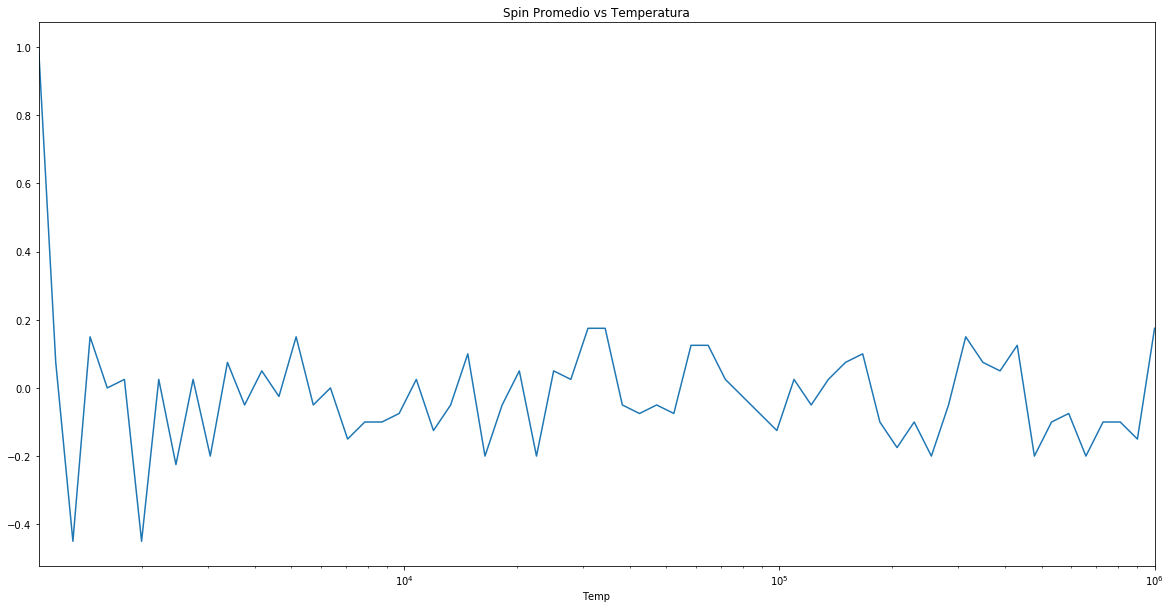

In [31]:
ax=df1D["Mean Spin"].plot(logx=True, title="Spin Promedio vs Temperatura")

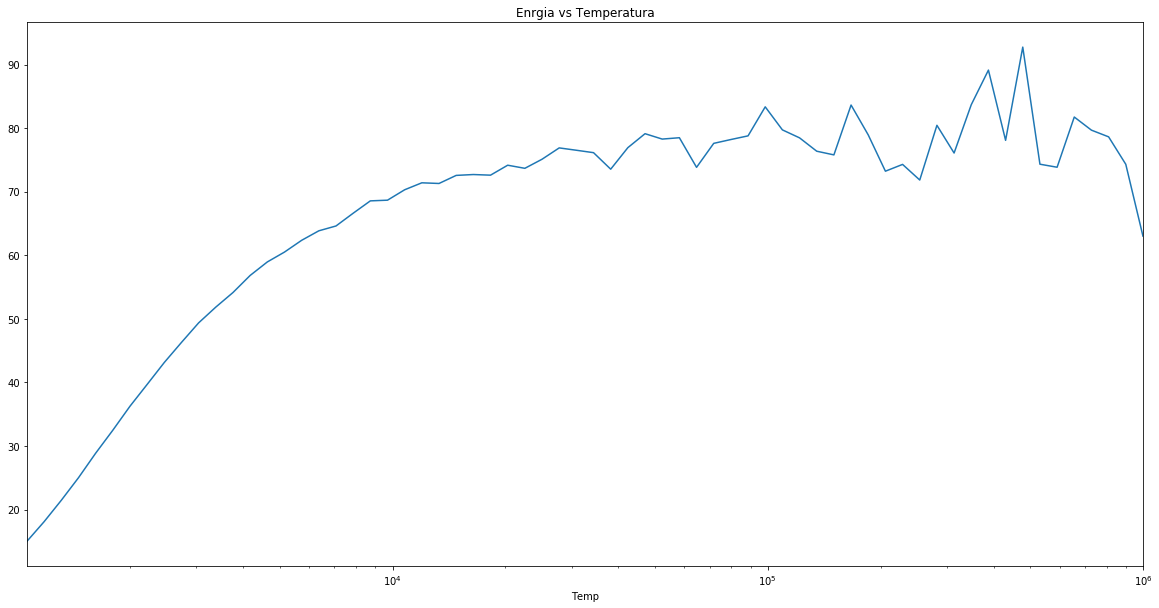

In [32]:
ax=df1D["Energy"].plot(logx=True, title="Enrgia vs Temperatura")

Metropolis 2D

Estado inicial, T = 1.00e+06


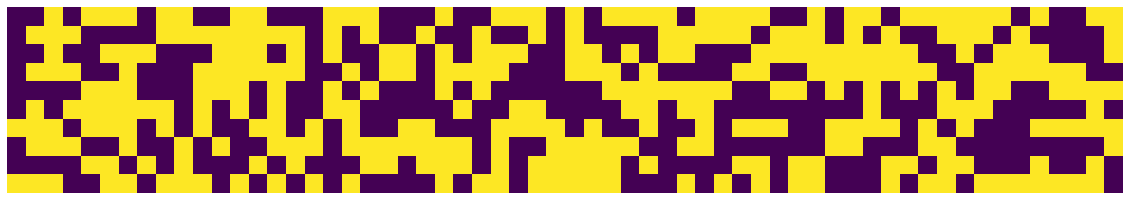

Temperature 1.00e+06, Mean Energy 1.14e+03


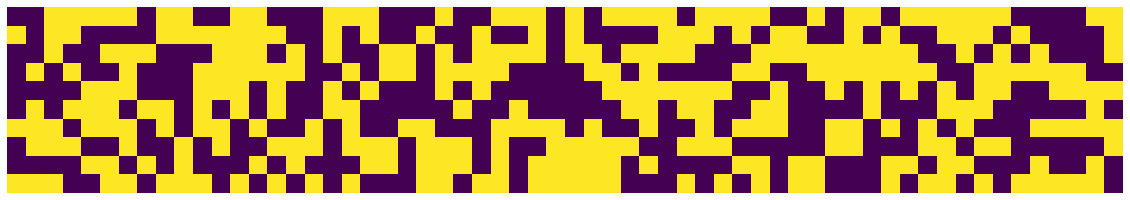

Temperature 9.00e+05, Mean Energy 1.12e+03


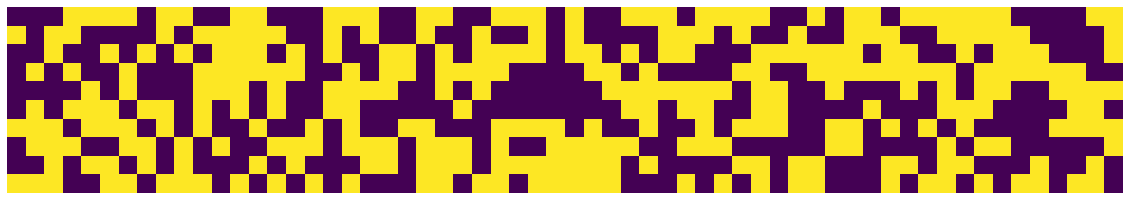

Temperature 8.10e+05, Mean Energy 1.12e+03


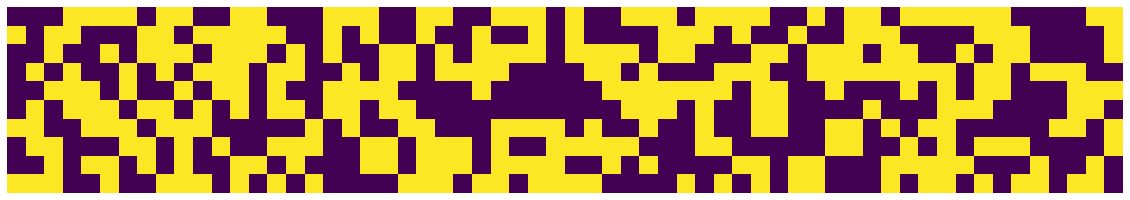

Temperature 7.29e+05, Mean Energy 1.10e+03


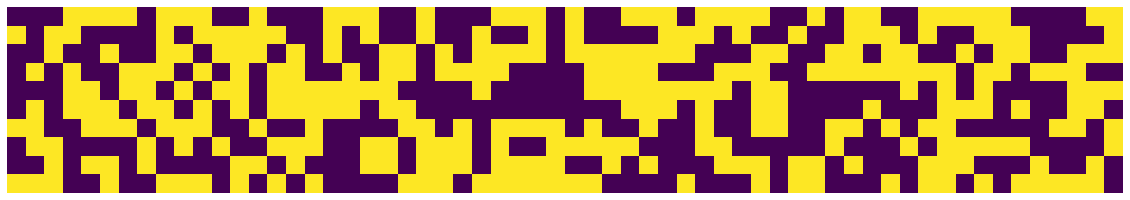

Temperature 6.56e+05, Mean Energy 1.10e+03


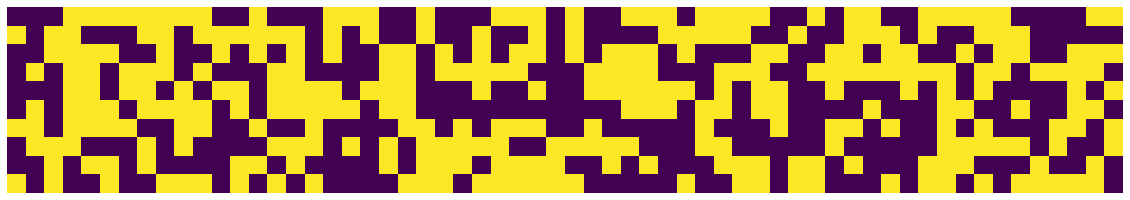

Temperature 5.90e+05, Mean Energy 1.09e+03


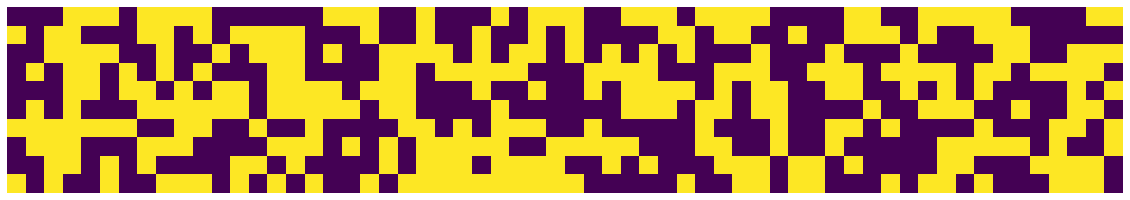

Temperature 5.31e+05, Mean Energy 1.08e+03


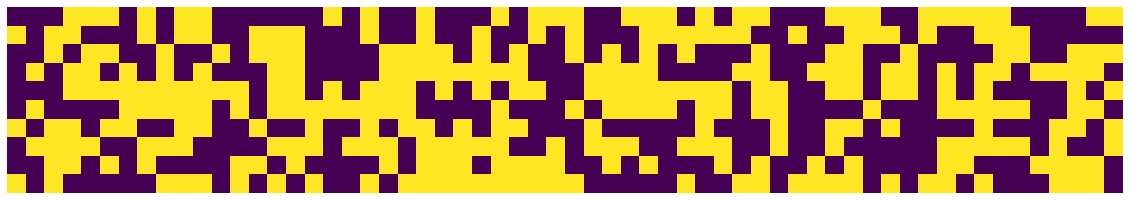

Temperature 4.78e+05, Mean Energy 1.11e+03


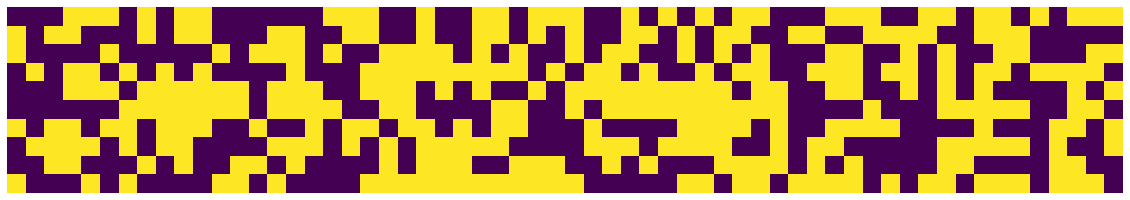

Temperature 4.30e+05, Mean Energy 1.11e+03


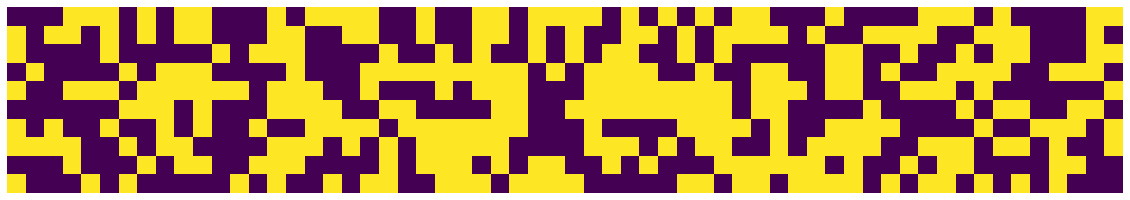

Temperature 3.87e+05, Mean Energy 1.17e+03


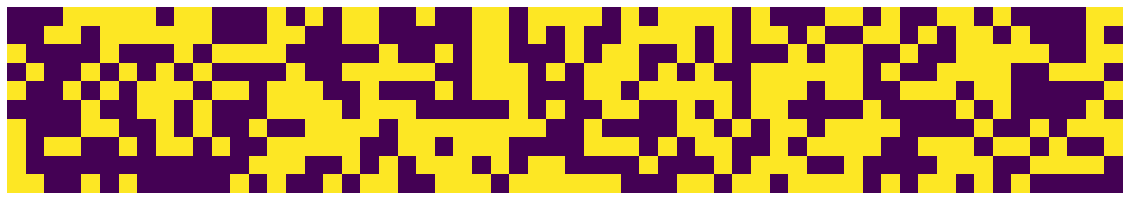

Temperature 3.49e+05, Mean Energy 1.15e+03


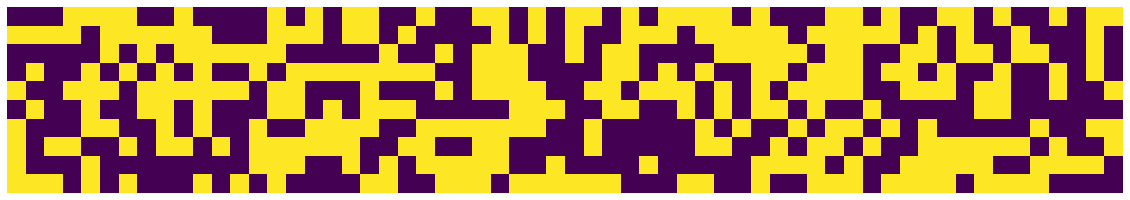

Temperature 3.14e+05, Mean Energy 1.14e+03


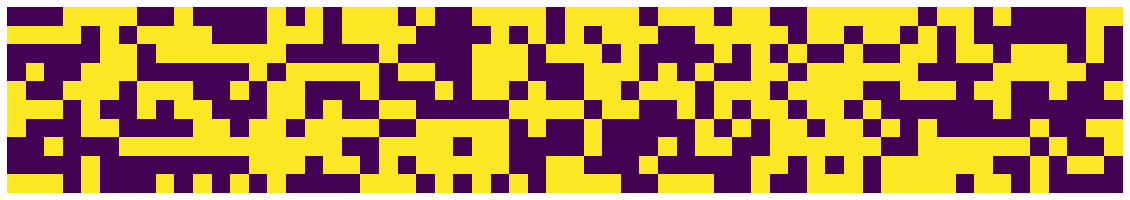

Temperature 2.82e+05, Mean Energy 1.18e+03


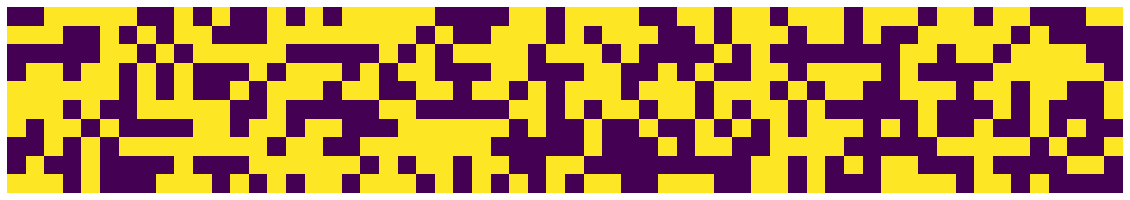

Temperature 2.54e+05, Mean Energy 1.12e+03


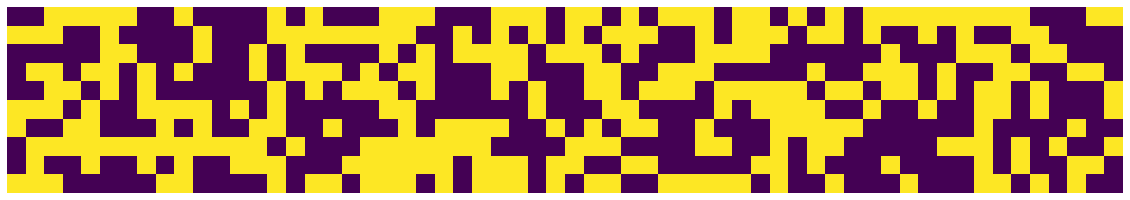

Temperature 2.29e+05, Mean Energy 1.16e+03


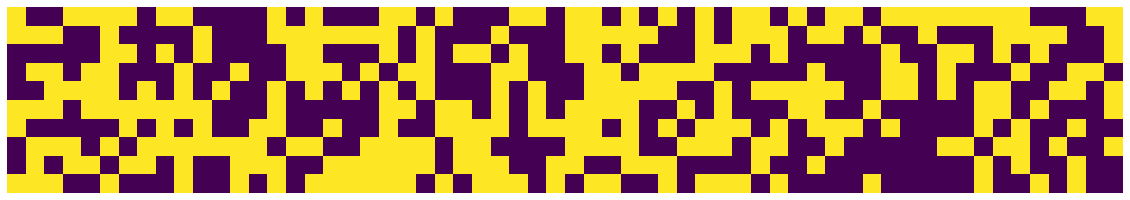

Temperature 2.06e+05, Mean Energy 1.11e+03


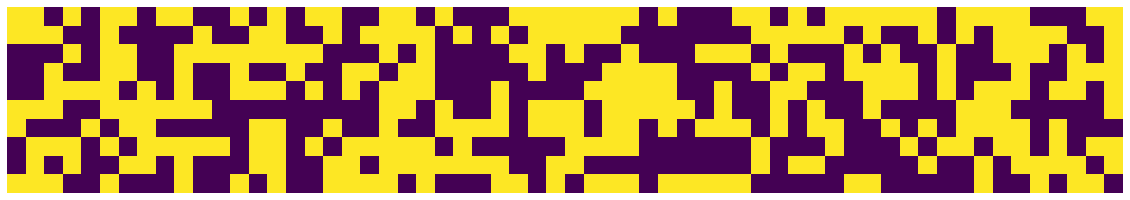

Temperature 1.85e+05, Mean Energy 1.10e+03


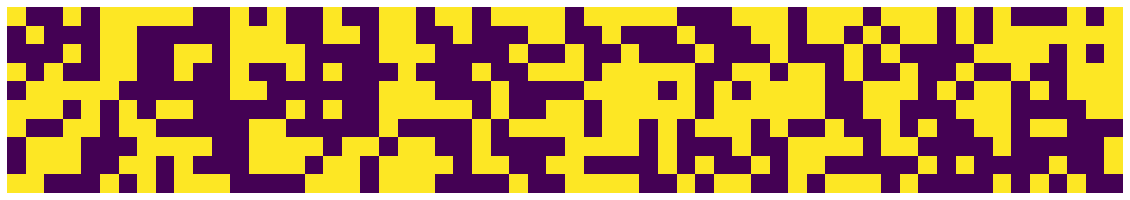

Temperature 1.67e+05, Mean Energy 1.12e+03


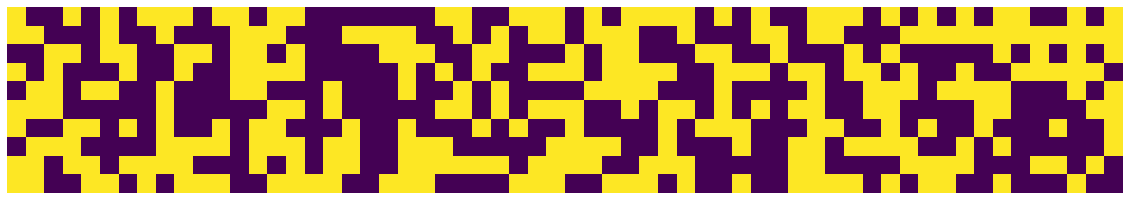

Temperature 1.50e+05, Mean Energy 1.18e+03


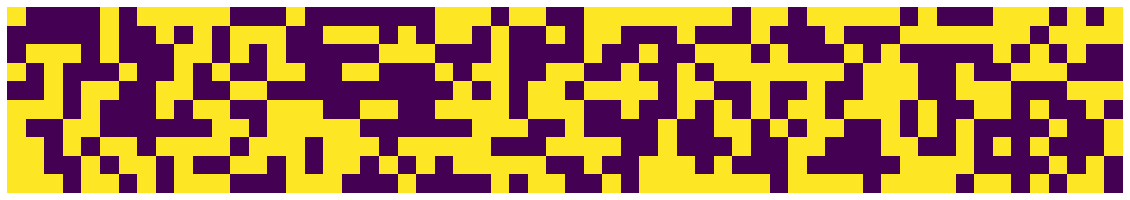

Temperature 1.35e+05, Mean Energy 1.12e+03


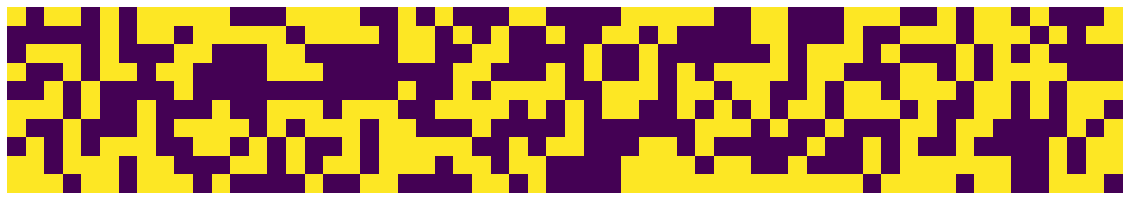

Temperature 1.22e+05, Mean Energy 1.15e+03


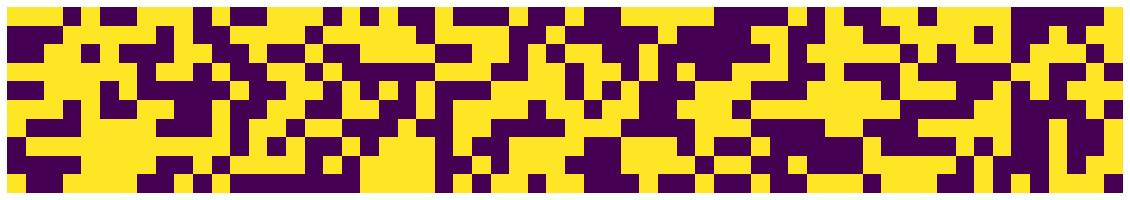

Temperature 1.09e+05, Mean Energy 1.14e+03


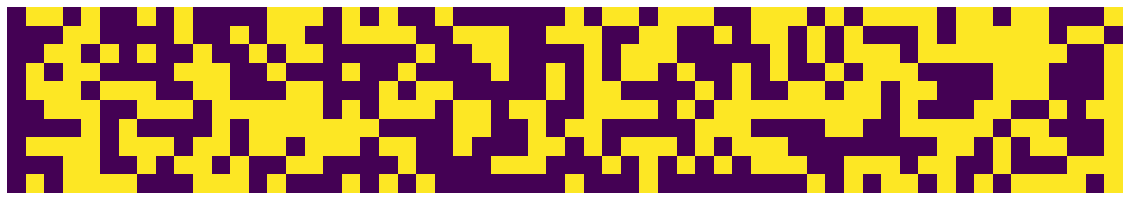

Temperature 9.85e+04, Mean Energy 1.14e+03


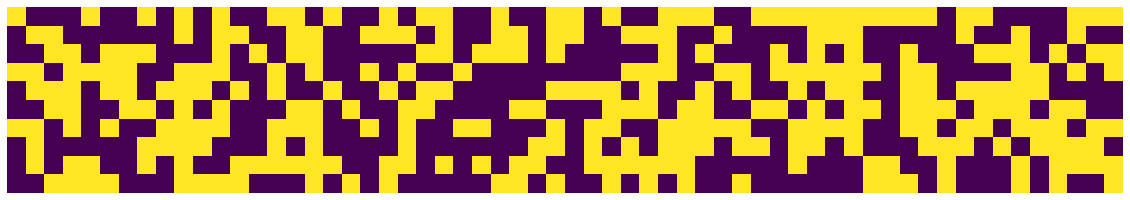

Temperature 8.86e+04, Mean Energy 1.13e+03


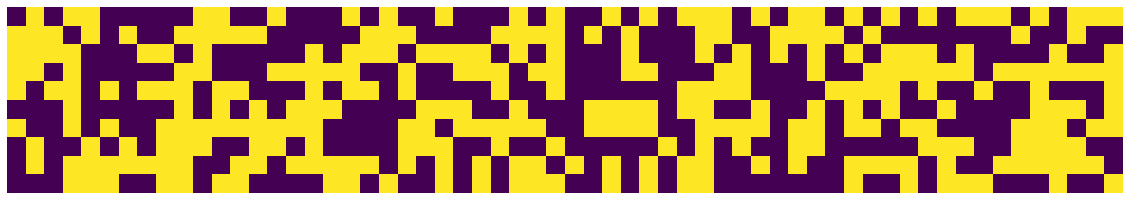

Temperature 7.98e+04, Mean Energy 1.14e+03


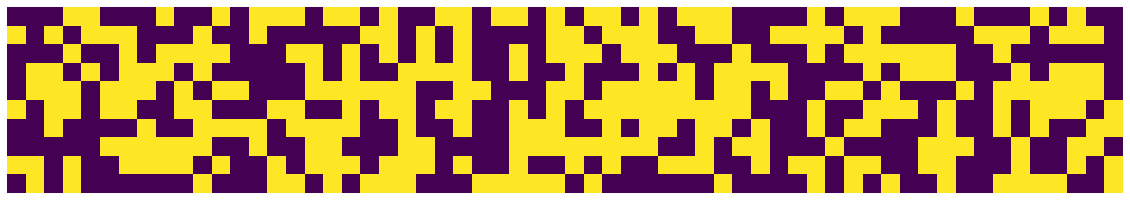

Temperature 7.18e+04, Mean Energy 1.10e+03


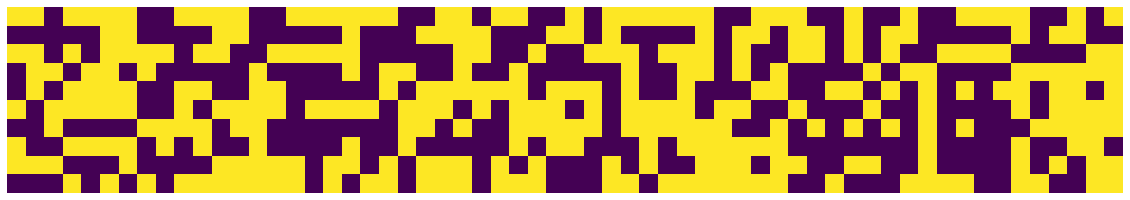

Temperature 6.46e+04, Mean Energy 1.08e+03


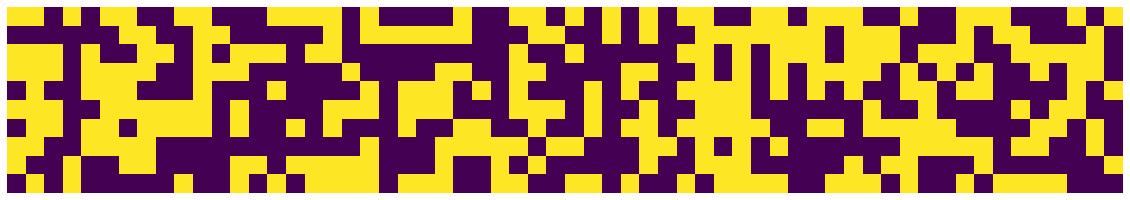

Temperature 5.81e+04, Mean Energy 1.11e+03


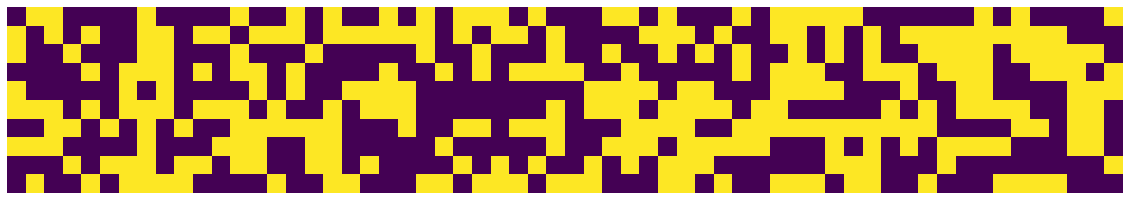

Temperature 5.23e+04, Mean Energy 1.10e+03


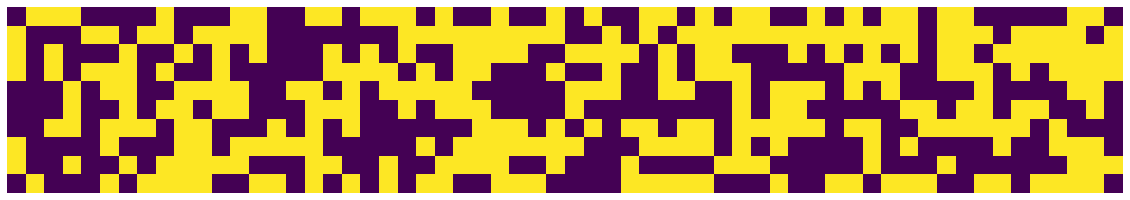

Temperature 4.71e+04, Mean Energy 1.14e+03


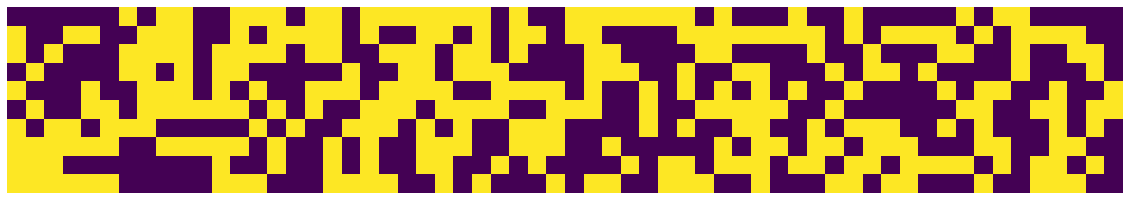

Temperature 4.24e+04, Mean Energy 1.10e+03


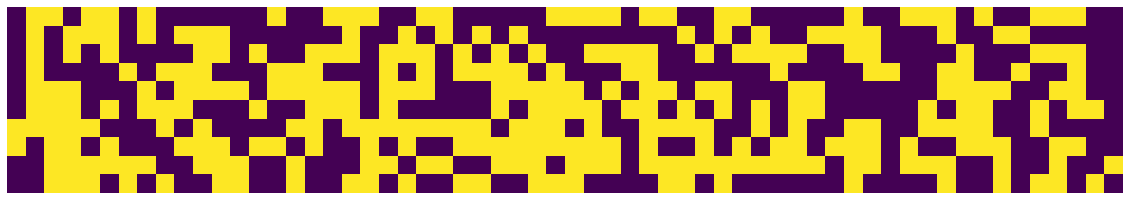

Temperature 3.82e+04, Mean Energy 1.06e+03


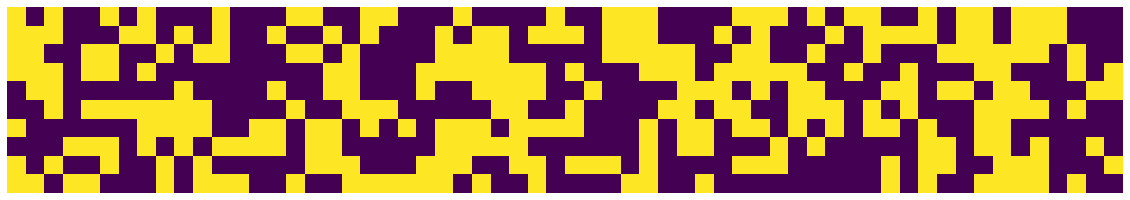

Temperature 3.43e+04, Mean Energy 1.01e+03


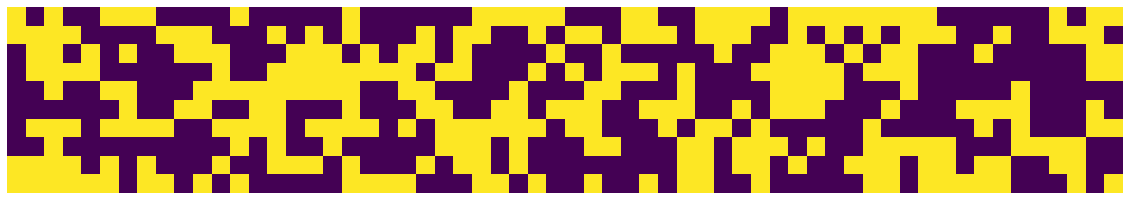

Temperature 3.09e+04, Mean Energy 1.05e+03


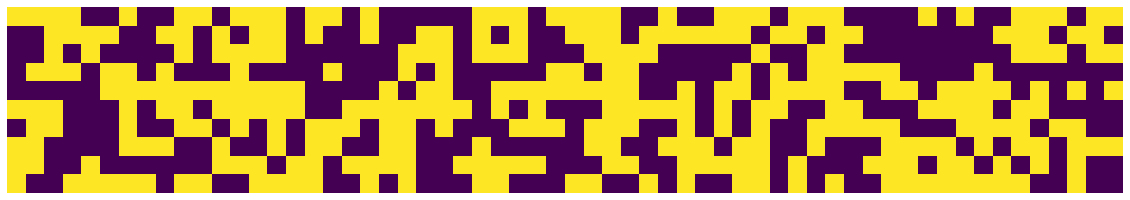

Temperature 2.78e+04, Mean Energy 1.10e+03


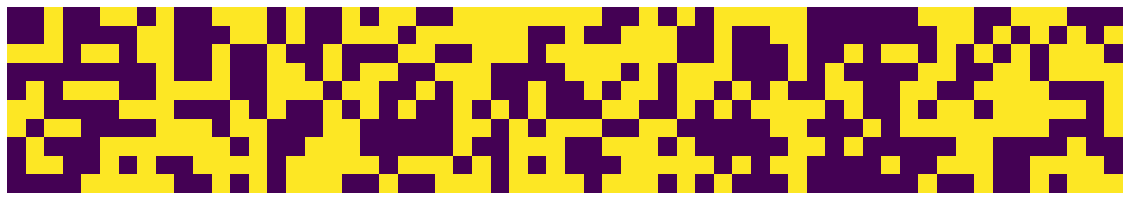

Temperature 2.50e+04, Mean Energy 1.08e+03                                      


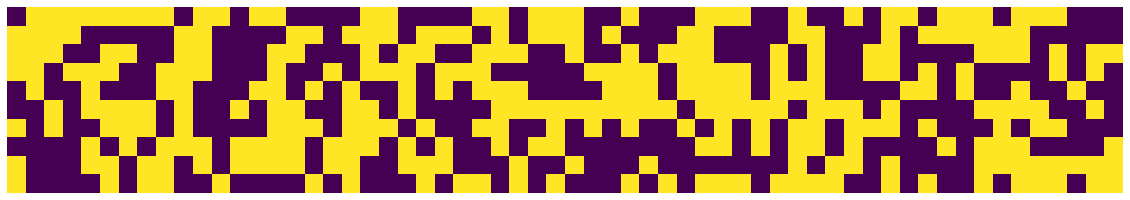

Temperature 2.25e+04, Mean Energy 1.01e+03                                      


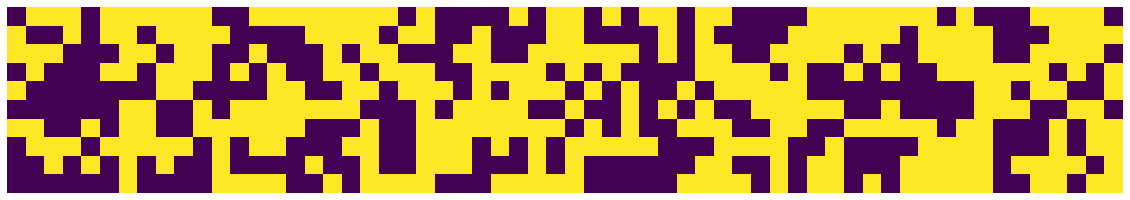

Temperature 2.03e+04, Mean Energy 1.09e+03                                      


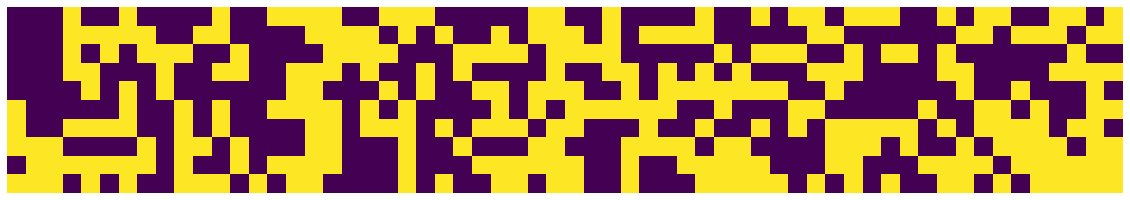

Temperature 1.82e+04, Mean Energy 1.07e+03


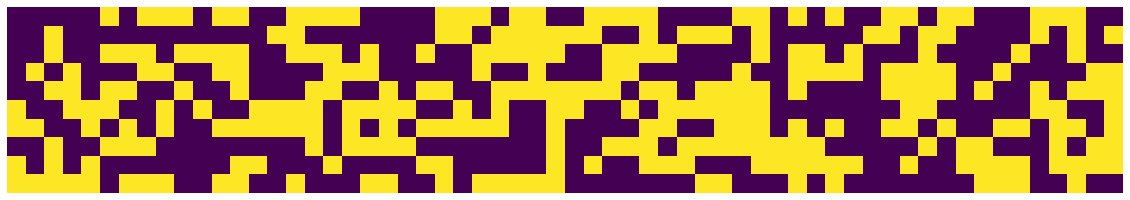

Temperature 1.64e+04, Mean Energy 1.04e+03


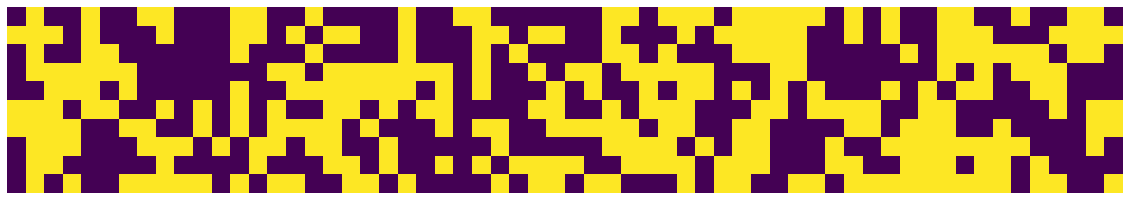

Temperature 1.48e+04, Mean Energy 1.00e+03                                      


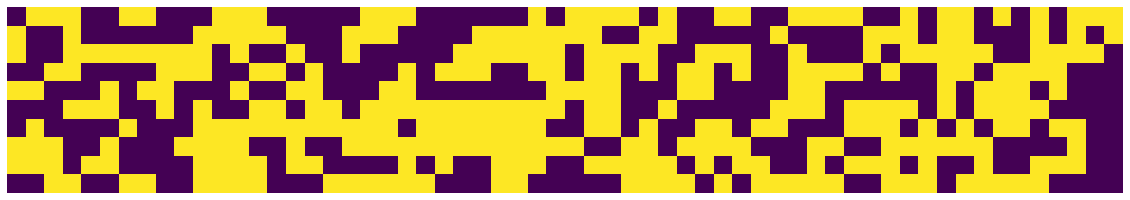

Temperature 1.33e+04, Mean Energy 1.05e+03                                      


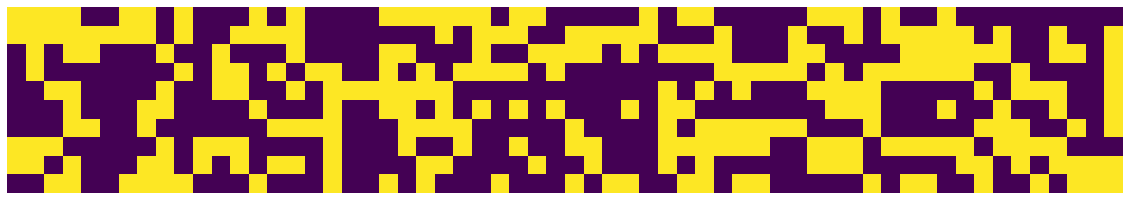

Temperature 1.20e+04, Mean Energy 1.02e+03                                      


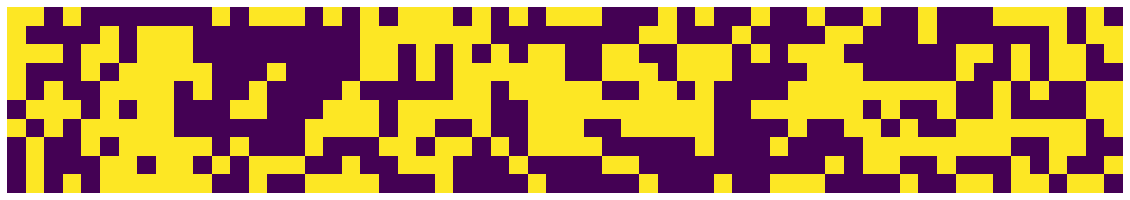

Temperature 1.08e+04, Mean Energy 1.04e+03                                      


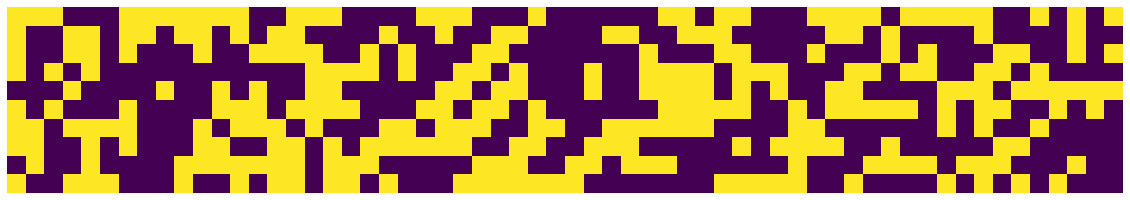

Temperature 9.70e+03, Mean Energy 9.60e+02


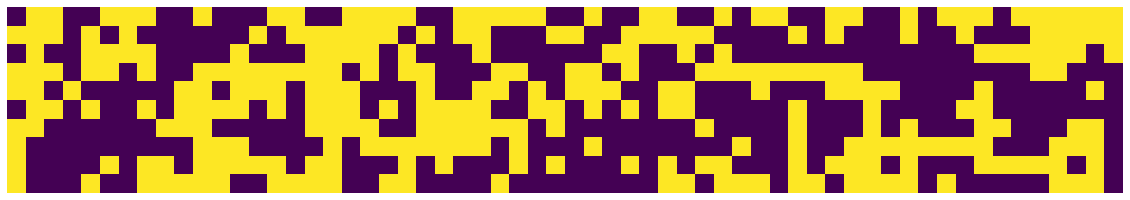

Temperature 8.73e+03, Mean Energy 9.68e+02                                      


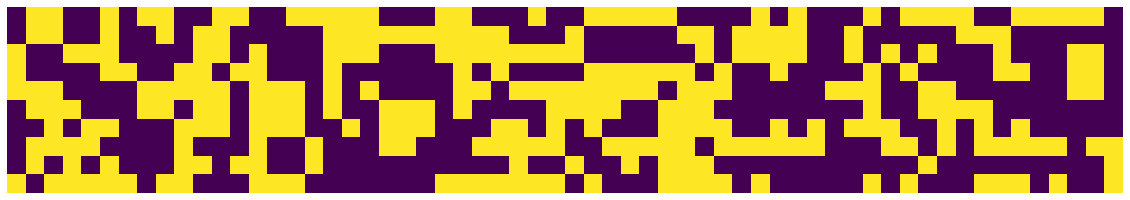

Temperature 7.86e+03, Mean Energy 9.36e+02                                      


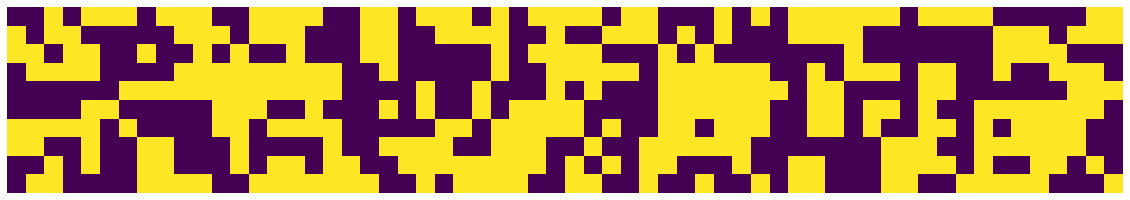

Temperature 7.07e+03, Mean Energy 9.38e+02                                      


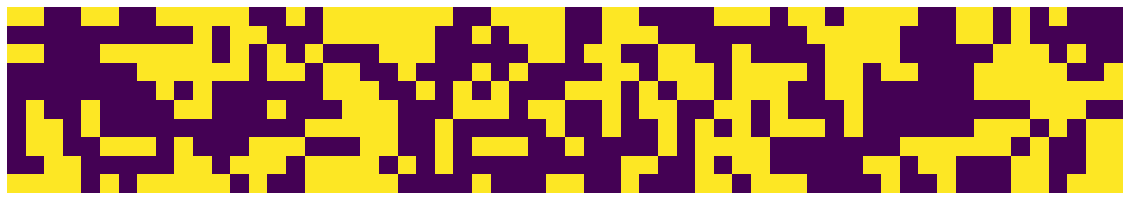

Temperature 6.36e+03, Mean Energy 8.28e+02                                      


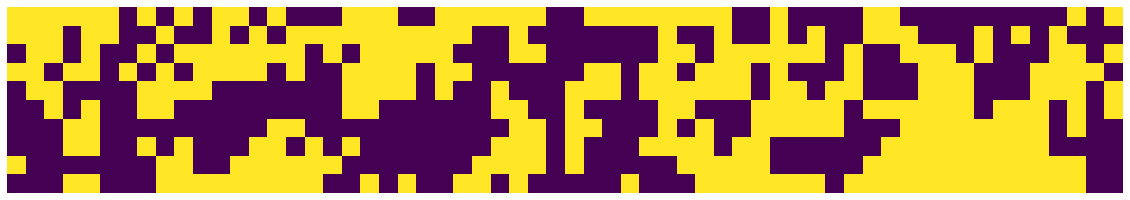

Temperature 5.73e+03, Mean Energy 8.90e+02                                      


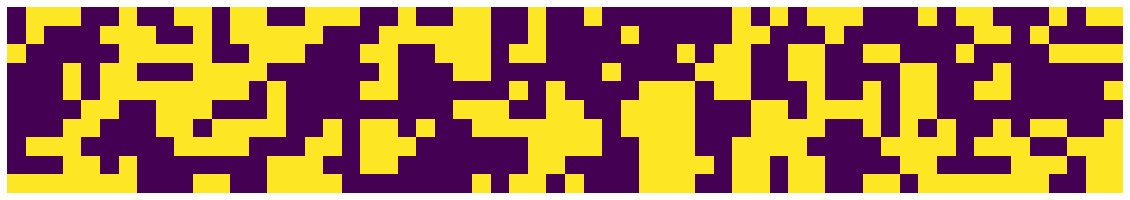

Temperature 5.15e+03, Mean Energy 8.66e+02                                      


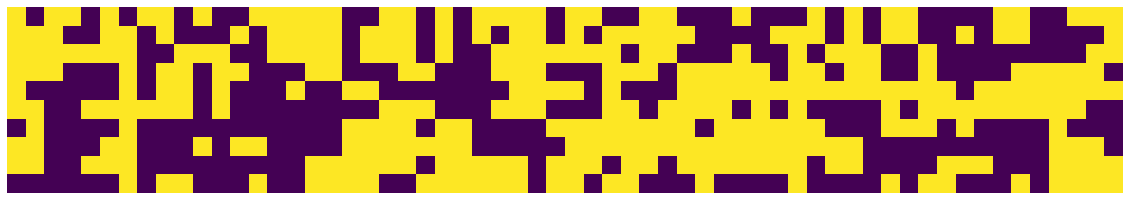

Temperature 4.64e+03, Mean Energy 7.04e+02                                      


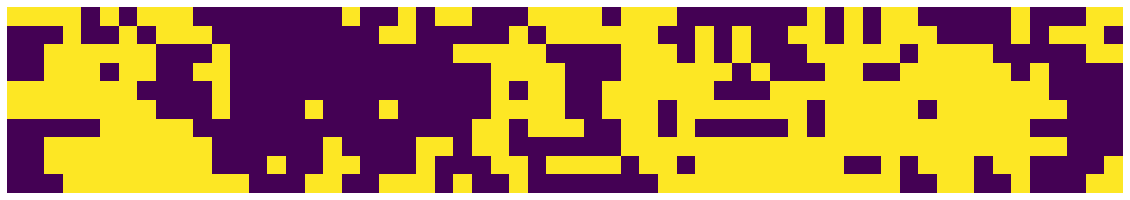

Temperature 4.17e+03, Mean Energy 7.12e+02                                      


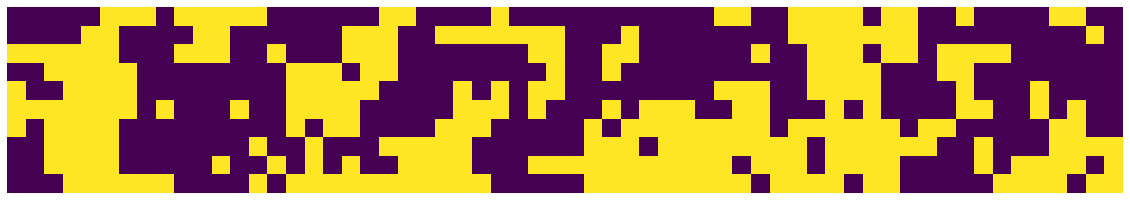

Temperature 3.76e+03, Mean Energy 7.06e+02                                      


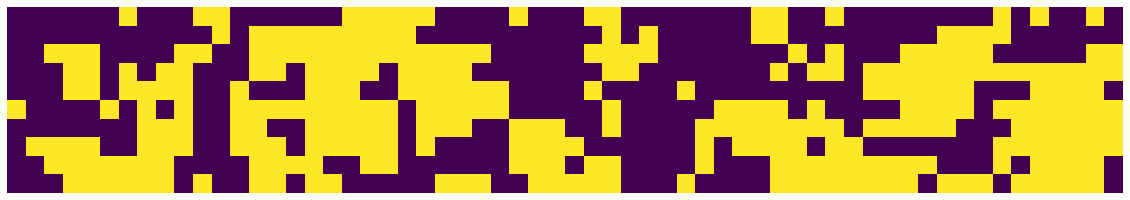

Temperature 3.38e+03, Mean Energy 6.36e+02                                      


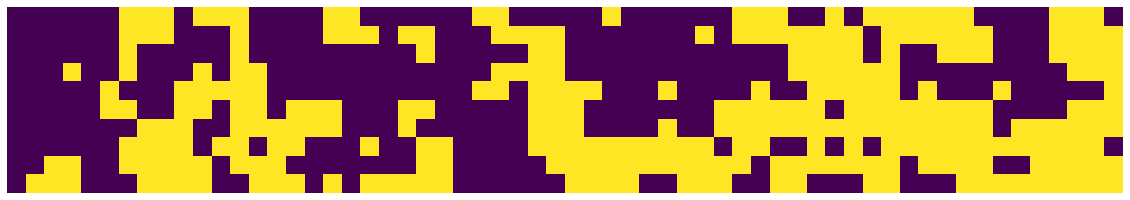

Temperature 3.04e+03, Mean Energy 5.34e+02                                      


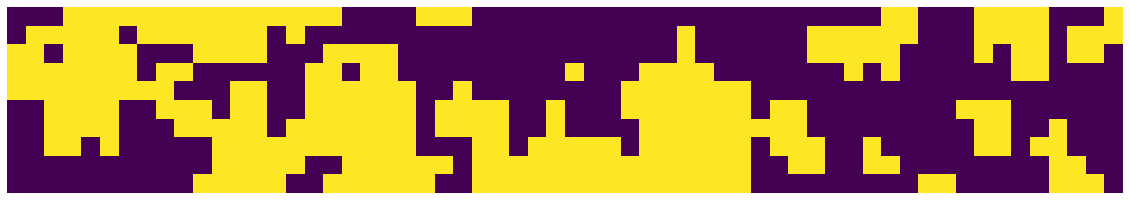

Temperature 2.74e+03, Mean Energy 4.52e+02                                      


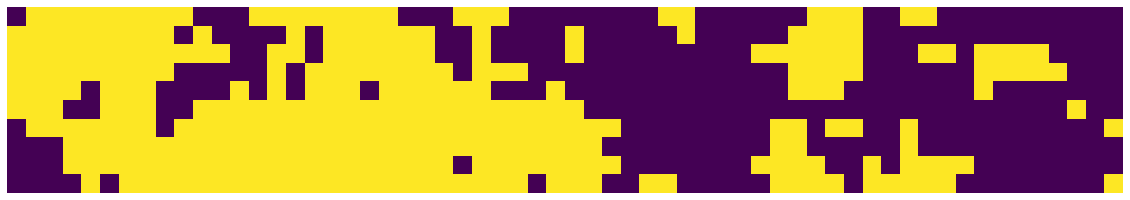

Temperature 2.47e+03, Mean Energy 2.66e+02                                      


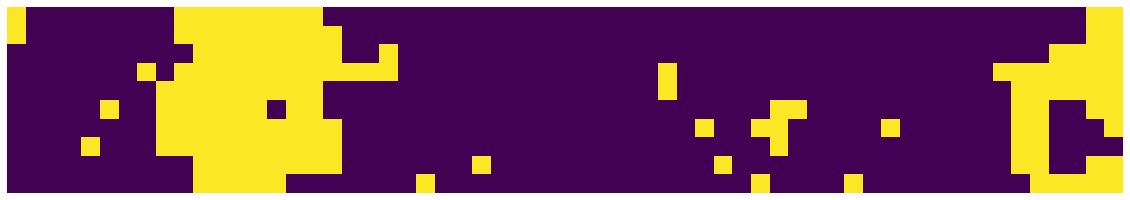

Temperature 2.22e+03, Mean Energy 1.94e+02                                      


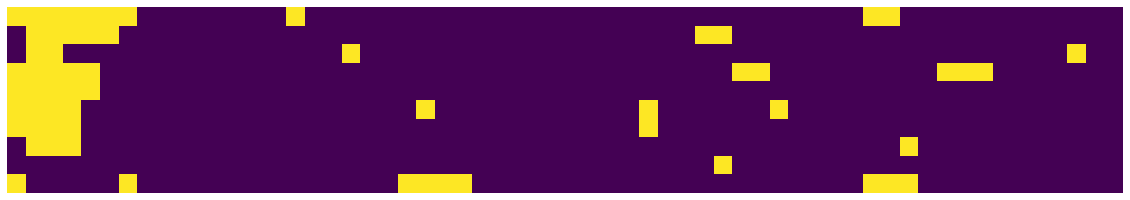

Temperature 2.00e+03, Mean Energy 1.22e+02                                      


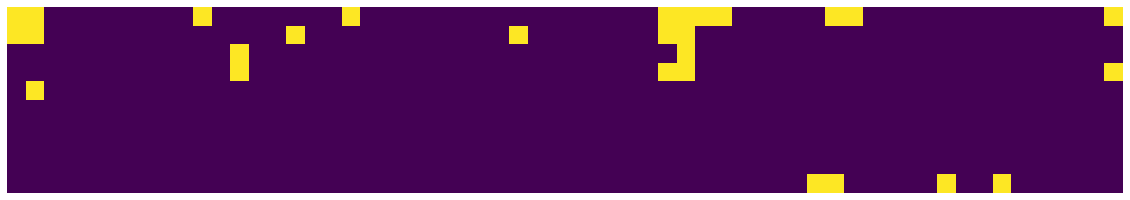

Temperature 1.80e+03, Mean Energy 0.00e+00                                      


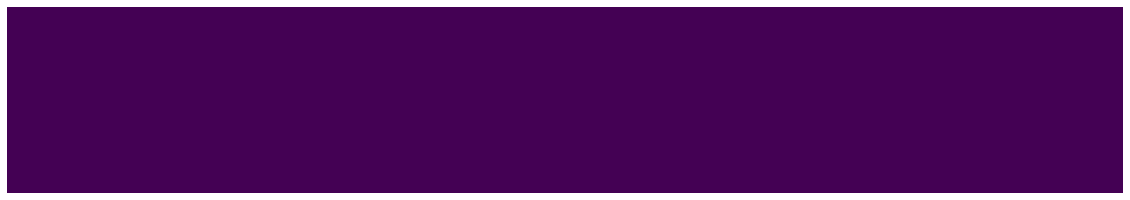

In [37]:
lattice=rand2dImageGen((10,60))
W=isingWeights(lattice)
result_2d=metropolis(lattice,W,1E6)

In [38]:
df2D=pd.DataFrame(result_2d,columns=["Temp","Energy","Mean Spin"]).set_index("Temp")

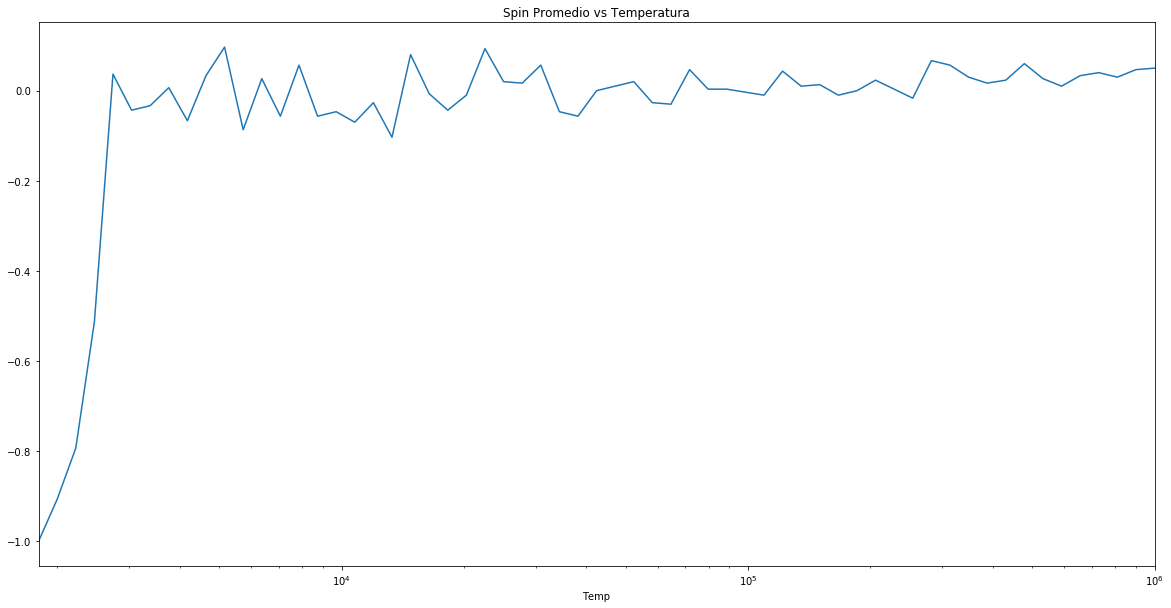

In [39]:
ax=df2D["Mean Spin"].plot(logx=True, title="Spin Promedio vs Temperatura")

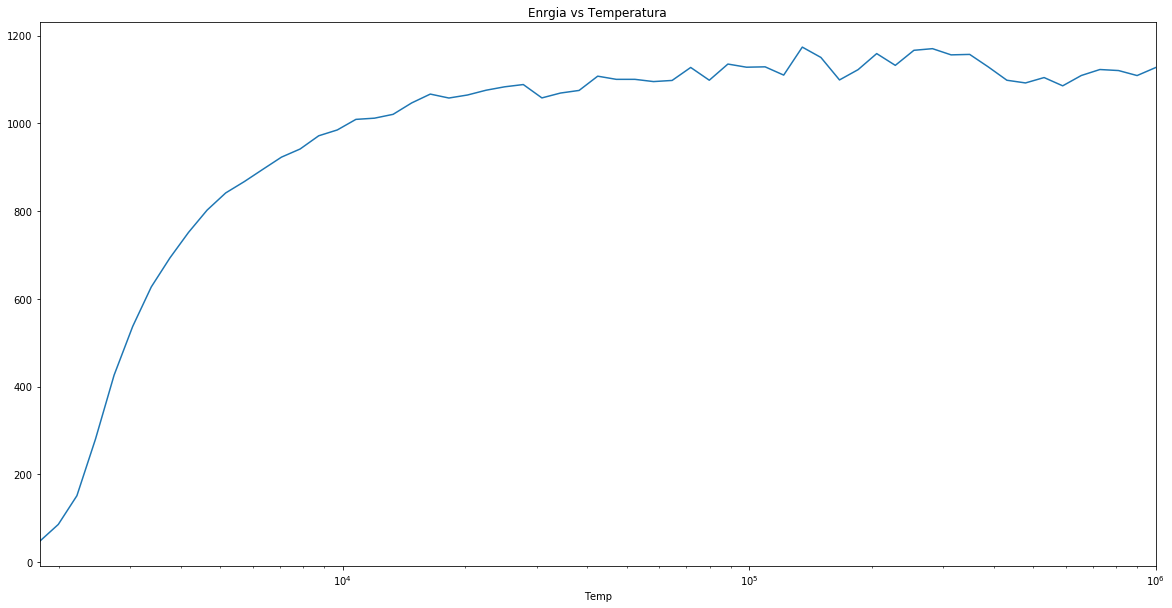

In [40]:
ax=df2D["Energy"].plot(logx=True, title="Enrgia vs Temperatura")